# NASA Exoplanet Data Cleaning & Wrangling

**Project:** K-Means Clustering Analysis of NASA Exoplanets 
---

## Objectives

This notebook demonstrates professional data wrangling practices:
   
1. **Identify and analyze missing values** in raw data
2. **Filter to complete cases** for clustering analysis
3. **Create derived variables** (density calculation)
4. **Standardize text fields** for consistency
5. **Detect and remove outliers** using statistical methods
6. **Export clean dataset** for downstream analysis

---

## Learning Outcomes Demonstrated

- ✅ Pandas data manipulation
- ✅ Missing value analysis and handling
- ✅ Data quality assessment
- ✅ Outlier detection methods
- ✅ Feature engineering
- ✅ Documentation and reproducibility

## 1. Setup and Data Loading

In [268]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")
print(f"Notebook execution started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully!
Notebook execution started: 2025-12-06 17:12:44


In [269]:
# Load raw data
INPUT_FILE = 'raw_exoplanets.csv'
OUTPUT_FILE = 'cleaned_exoplanets.csv'

print(f"Loading data from: {INPUT_FILE}")
df_raw = pd.read_csv(INPUT_FILE)

print(f"\n✓ Data loaded successfully!")
print(f"  Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print(f"\nColumn names:\n{df_raw.columns.tolist()}")

Loading data from: raw_exoplanets.csv

✓ Data loaded successfully!
  Shape: 39,158 rows × 9 columns

Column names:
['pl_name', 'pl_masse', 'pl_rade', 'pl_orbper', 'pl_eqt', 'sy_dist', 'discoverymethod', 'disc_year', 'hostname']


In [270]:
# Display first few rows
print("First 5 rows of raw data:")
df_raw.head()

First 5 rows of raw data:


,pl_name,pl_masse,pl_rade,pl_orbper,pl_eqt,sy_dist,discoverymethod,disc_year,hostname
0,WASP-39 b,88.9890,14.2350,4.0553,NaN,213.9820,Transit,2011,WASP-39
1,HAT-P-1 b,169.0856,13.9216,4.4654,1306.0000,158.9790,Transit,2006,HAT-P-1
2,HR 8799 d,3000.0000,13.0000,37000.0000,NaN,41.2441,Imaging,2008,HR 8799
3,HD 156279 b,NaN,NaN,131.0500,NaN,36.1945,Radial Velocity,2011,HD 156279
4,GJ 832 b,NaN,NaN,3507.0000,NaN,4.9643,Radial Velocity,2008,GJ 832


In [271]:
# Basic info about the dataset
print("Dataset Information:")
df_raw.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39158 entries, 0 to 39157
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pl_name          39158 non-null  object 
 1   pl_masse         4740 non-null   float64
 2   pl_rade          26999 non-null  float64
 3   pl_orbper        35879 non-null  float64
 4   pl_eqt           17159 non-null  float64
 5   sy_dist          38314 non-null  float64
 6   discoverymethod  39158 non-null  object 
 7   disc_year        39158 non-null  int64  
 8   hostname         39158 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 2.7+ MB


## 2. Deduplicate Planets

The NASA Exoplanet Archive contains multiple parameter sets for many planets.
We need to consolidate these into single entries per planet by averaging
non-null values across all measurements.

In [272]:
print("="*80)
print("DUPLICATE PLANET ANALYSIS")
print("="*80)

# Check for duplicate planet names
duplicate_counts = df_raw['pl_name'].value_counts()
n_unique_planets = duplicate_counts.shape[0]
n_total_rows = len(df_raw)

print(f"\nTotal rows in dataset: {n_total_rows:,}")
print(f"Unique planet names: {n_unique_planets:,}")
print(f"Duplicate entries: {n_total_rows - n_unique_planets:,}")

# Show planets with most duplicates
print(f"\nTop 10 planets with most duplicate entries:")
print(duplicate_counts.head(10))

# Analyze how many planets have duplicates
planets_with_duplicates = (duplicate_counts > 1).sum()
print(f"\nPlanets with multiple entries: {planets_with_duplicates:,} ({planets_with_duplicates/n_unique_planets*100:.1f}%)")
print(f"Planets with single entry: {(duplicate_counts == 1).sum():,} ({(duplicate_counts == 1).sum()/n_unique_planets*100:.1f}%)")

print("="*80)


DUPLICATE PLANET ANALYSIS

Total rows in dataset: 39,158
Unique planet names: 6,053
Duplicate entries: 33,105

Top 10 planets with most duplicate entries:
pl_name
TrES-2 b       34
Kepler-10 b    25
HD 209458 b    23
GJ 436 b       23
HAT-P-7 b      23
HAT-P-11 b     22
HD 189733 b    21
Kepler-10 c    21
Kepler-25 c    21
KOI-13 b       20
Name: count, dtype: int64

Planets with multiple entries: 5,174 (85.5%)
Planets with single entry: 879 (14.5%)


In [273]:
print("\n" + "="*80)
print("MEASUREMENT VARIANCE ANALYSIS (Before Deduplication)")
print("="*80)
print("\nAnalyzing the range of values for planets with multiple measurements...")
print("This reveals uncertainty introduced by averaging duplicate entries.\n")

# Use the ORIGINAL df_raw (before deduplication)
# Get the DataFrame that was loaded initially
df_before_dedup = pd.read_csv('raw_exoplanets.csv')

# Get duplicate counts
duplicate_counts_analysis = df_before_dedup['pl_name'].value_counts()
duplicate_planet_names = duplicate_counts_analysis[duplicate_counts_analysis > 1].index

print(f"Planets with multiple entries: {len(duplicate_planet_names):,}")
print(f"Total duplicate entries to analyze: {(duplicate_counts_analysis > 1).sum():,}")

# Analyze variance for each numerical feature
numerical_features_to_analyze = ['pl_masse', 'pl_rade', 'pl_orbper', 'pl_eqt', 'sy_dist']

variance_stats = {}

for feature in numerical_features_to_analyze:
    if feature not in df_before_dedup.columns:
        print(f"  Skipping {feature} - not found in data")
        continue
    
    # For each planet with duplicates, calculate the range
    ranges = []
    
    for planet_name in duplicate_planet_names:
        planet_data = df_before_dedup[df_before_dedup['pl_name'] == planet_name][feature].dropna()
        
        if len(planet_data) > 1:  # Only if multiple non-null values
            value_range = planet_data.max() - planet_data.min()
            mean_value = planet_data.mean()
            
            # Calculate relative range (range as % of mean)
            if mean_value != 0:
                relative_range = (value_range / abs(mean_value)) * 100
                ranges.append({
                    'planet': planet_name,
                    'n_measurements': len(planet_data),
                    'min': planet_data.min(),
                    'max': planet_data.max(),
                    'range': value_range,
                    'mean': mean_value,
                    'relative_range_pct': relative_range
                })
    
    if ranges:
        variance_stats[feature] = pd.DataFrame(ranges)
        print(f"  ✓ {feature}: {len(ranges):,} planets with multiple measurements")
    else:
        print(f"  ⚠ {feature}: No planets with multiple non-null measurements")

print("\n" + "="*80)

# Display summary statistics for each feature
if variance_stats:
    print("\nSUMMARY: Measurement Variability for Planets with Multiple Entries")
    print("-" * 80)
    
    for feature, df_var in variance_stats.items():
        print(f"\n{feature}:")
        print(f"  Planets analyzed: {len(df_var):,}")
        print(f"  Average absolute range: {df_var['range'].mean():.4f}")
        print(f"  Average relative range: {df_var['relative_range_pct'].mean():.2f}%")
        print(f"  Median relative range: {df_var['relative_range_pct'].median():.2f}%")
        print(f"  Max relative range: {df_var['relative_range_pct'].max():.2f}%")
        
        # Show examples of high variance
        if len(df_var) >= 3:
            high_variance = df_var.nlargest(3, 'relative_range_pct')
            print(f"  Top 3 most variable:")
            for idx, row in high_variance.iterrows():
                print(f"    • {row['planet']}: {row['min']:.2f} to {row['max']:.2f} " +
                      f"(±{row['relative_range_pct']:.1f}%, n={int(row['n_measurements'])})")
else:
    print("\n⚠ WARNING: No variance statistics calculated!")
    print("   This may indicate an issue with the data or duplicate detection.")

print("\n" + "="*80)


MEASUREMENT VARIANCE ANALYSIS (Before Deduplication)

Analyzing the range of values for planets with multiple measurements...
This reveals uncertainty introduced by averaging duplicate entries.

Planets with multiple entries: 5,174
Total duplicate entries to analyze: 5,174
  ✓ pl_masse: 1,062 planets with multiple measurements
  ✓ pl_rade: 4,322 planets with multiple measurements
  ✓ pl_orbper: 4,954 planets with multiple measurements
  ✓ pl_eqt: 3,952 planets with multiple measurements
  ✓ sy_dist: 5,070 planets with multiple measurements


SUMMARY: Measurement Variability for Planets with Multiple Entries
--------------------------------------------------------------------------------

pl_masse:
  Planets analyzed: 1,062
  Average absolute range: 354.8605
  Average relative range: 50.74%
  Median relative range: 18.91%
  Max relative range: 594.21%
  Top 3 most variable:
    • Kepler-25 b: 1.63 to 4036.30 (±594.2%, n=6)
    • Kepler-25 c: 2.35 to 1322.12 (±568.1%, n=6)
    • Kepler-

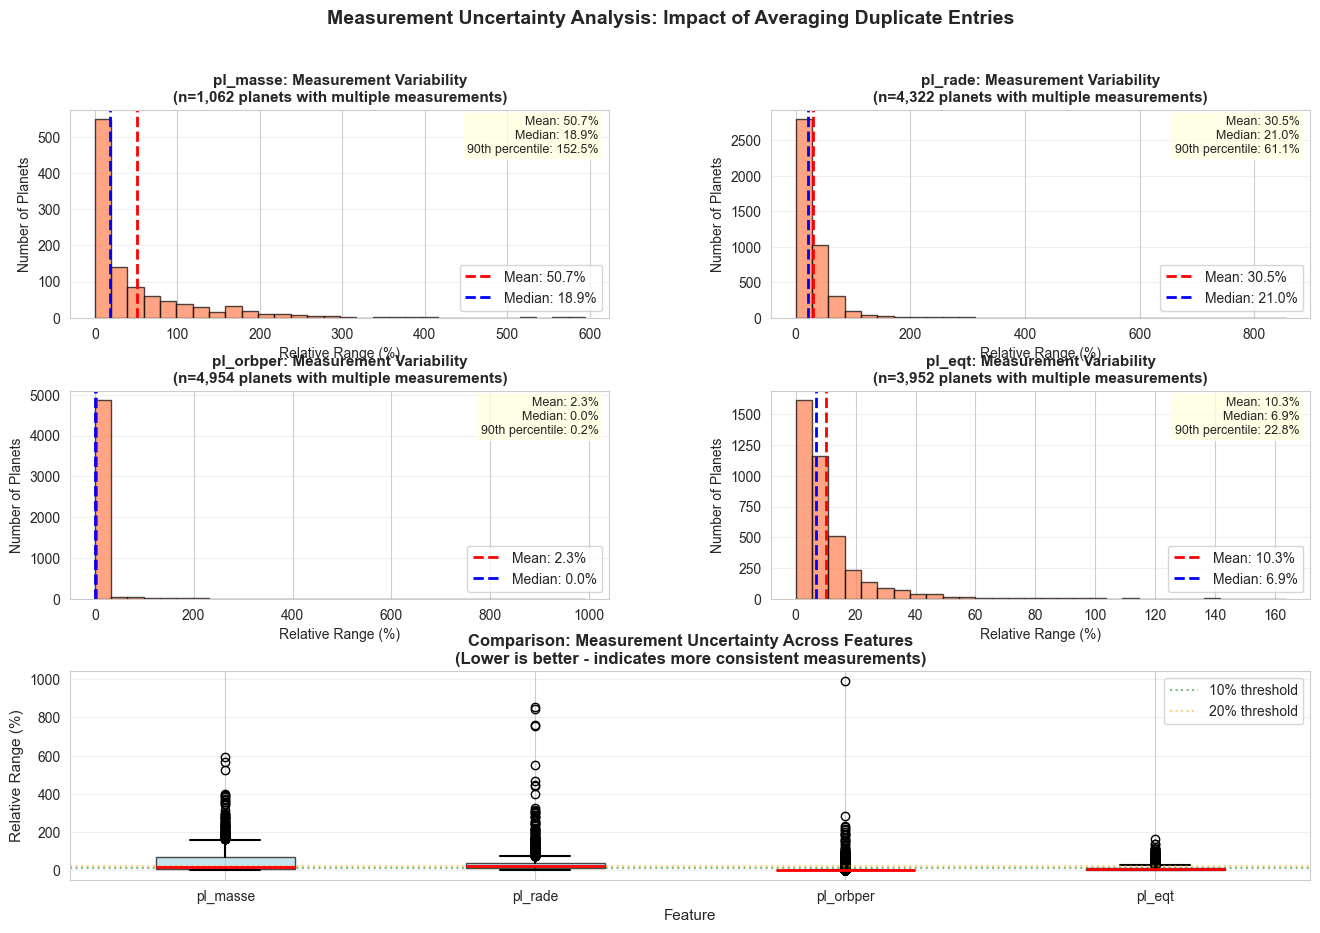


✓ Visualization saved as 'deduplication_uncertainty.png'


In [274]:
if not variance_stats:
    print("\n⚠ Cannot create variance visualization - no variance data available")
    print("   Make sure this code runs BEFORE deduplication")
else:
    # Create comprehensive visualization of measurement variance
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)
    
    # We'll plot the 4 main clustering features
    features_to_plot = ['pl_masse', 'pl_rade', 'pl_orbper', 'pl_eqt']
    plot_idx = 0
    
    for i, feature in enumerate(features_to_plot):
        if feature not in variance_stats or len(variance_stats[feature]) == 0:
            continue
        
        df_var = variance_stats[feature]
        
        row = plot_idx // 2
        col = plot_idx % 2
        
        # Histogram of relative ranges
        ax = fig.add_subplot(gs[row, col])
        
        df_var['relative_range_pct'].hist(bins=30, ax=ax, color='coral', 
                                          edgecolor='black', alpha=0.7)
        
        mean_rel_range = df_var['relative_range_pct'].mean()
        median_rel_range = df_var['relative_range_pct'].median()
        
        ax.axvline(mean_rel_range, color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {mean_rel_range:.1f}%')
        ax.axvline(median_rel_range, color='blue', linestyle='--', linewidth=2,
                   label=f'Median: {median_rel_range:.1f}%')
        
        ax.set_xlabel('Relative Range (%)')
        ax.set_ylabel('Number of Planets')
        ax.set_title(f'{feature}: Measurement Variability\n' + 
                     f'(n={len(df_var):,} planets with multiple measurements)',
                     fontweight='bold', fontsize=11)
        ax.legend()
        ax.grid(alpha=0.3, axis='y')
        
        # Add statistics box
        stats_text = f'Mean: {mean_rel_range:.1f}%\n'
        stats_text += f'Median: {median_rel_range:.1f}%\n'
        stats_text += f'90th percentile: {df_var["relative_range_pct"].quantile(0.90):.1f}%'
        
        ax.text(0.98, 0.97, stats_text,
                transform=ax.transAxes, ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
                fontsize=9)
        
        plot_idx += 1
    
    # Bottom row: Comparison across features
    if plot_idx > 0:  # Only if we plotted something
        ax_bottom = fig.add_subplot(gs[2, :])
        
        # Box plot comparing relative ranges across features
        data_to_plot = []
        labels_to_plot = []
        
        for feature in features_to_plot:
            if feature in variance_stats and len(variance_stats[feature]) > 0:
                data_to_plot.append(variance_stats[feature]['relative_range_pct'].values)
                labels_to_plot.append(feature)
        
        # Only create boxplot if we have data
        if len(data_to_plot) > 0:
            bp = ax_bottom.boxplot(data_to_plot, labels=labels_to_plot, patch_artist=True,
                                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                                    medianprops=dict(color='red', linewidth=2),
                                    whiskerprops=dict(linewidth=1.5),
                                    capprops=dict(linewidth=1.5))
            
            ax_bottom.set_ylabel('Relative Range (%)', fontsize=11)
            ax_bottom.set_xlabel('Feature', fontsize=11)
            ax_bottom.set_title('Comparison: Measurement Uncertainty Across Features\n' +
                                 '(Lower is better - indicates more consistent measurements)',
                                 fontweight='bold', fontsize=12)
            ax_bottom.grid(alpha=0.3, axis='y')
            ax_bottom.axhline(10, color='green', linestyle=':', linewidth=1.5, 
                              alpha=0.5, label='10% threshold')
            ax_bottom.axhline(20, color='orange', linestyle=':', linewidth=1.5,
                              alpha=0.5, label='20% threshold')
            ax_bottom.legend(loc='upper right')
    
    plt.suptitle('Measurement Uncertainty Analysis: Impact of Averaging Duplicate Entries',
                 fontsize=14, fontweight='bold')
    plt.savefig('deduplication_uncertainty.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Visualization saved as 'deduplication_uncertainty.png'")

In [275]:
if variance_stats:
    print("\n" + "="*80)
    print("DETAILED VARIANCE REPORT")
    print("="*80)
    
    variance_report = """
INTERPRETATION GUIDE:
--------------------
Relative Range % = (Max - Min) / Mean × 100

• < 10%:  Low variance - measurements are consistent
• 10-25%: Moderate variance - typical measurement uncertainty
• > 25%:  High variance - significant disagreement between sources
• > 50%:  Very high variance - caution interpreting averaged value

"""
    
    print(variance_report)
    
    # Create summary table
    summary_data = []
    features_to_plot = ['pl_masse', 'pl_rade', 'pl_orbper', 'pl_eqt']
    
    for feature in features_to_plot:
        if feature in variance_stats and len(variance_stats[feature]) > 0:
            df_var = variance_stats[feature]
            summary_data.append({
                'Feature': feature,
                'Planets_Multi_Meas': len(df_var),
                'Mean_Rel_Range_%': df_var['relative_range_pct'].mean(),
                'Median_Rel_Range_%': df_var['relative_range_pct'].median(),
                '90th_Percentile_%': df_var['relative_range_pct'].quantile(0.90),
                'Planets_>25%_Var': (df_var['relative_range_pct'] > 25).sum()
            })
    
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        print("\nSUMMARY TABLE:")
        print(summary_df.to_string(index=False))
        
        print("\n" + "-"*80)
        print("KEY FINDINGS:")
        print("-"*80)
        
        for feature in features_to_plot:
            if feature in variance_stats and len(variance_stats[feature]) > 0:
                df_var = variance_stats[feature]
                mean_var = df_var['relative_range_pct'].mean()
                high_var = (df_var['relative_range_pct'] > 25).sum()
                pct_high_var = (high_var / len(df_var) * 100)
                
                if mean_var < 10:
                    quality = "EXCELLENT"
                elif mean_var < 20:
                    quality = "GOOD"
                elif mean_var < 30:
                    quality = "MODERATE"
                else:
                    quality = "CAUTION"
                
                print(f"\n{feature}: [{quality}]")
                print(f"  Average uncertainty: ±{mean_var:.1f}%")
                print(f"  {high_var:,} planets ({pct_high_var:.1f}%) have >25% variance")
                
                if quality == "CAUTION":
                    print(f"  ⚠ High variance detected - averaging may obscure true values")
                elif quality == "EXCELLENT":
                    print(f"  ✓ Low variance - averaged values are reliable")
    
    print("\n" + "="*80)
    print("CONCLUSION:")
    print("="*80)
    print("""
By analyzing measurement variance, we can assess the reliability of our
averaged values. This transparency is crucial for:

1. Understanding uncertainty in our clustering analysis
2. Identifying which features have more reliable measurements
3. Recognizing limitations when interpreting results
4. Justifying our data cleaning methodology

Lower relative ranges indicate that different measurement sources agree,
giving us confidence that averaging is a reasonable consolidation strategy.
""")
    print("="*80)


DETAILED VARIANCE REPORT

INTERPRETATION GUIDE:
--------------------
Relative Range % = (Max - Min) / Mean × 100

• < 10%:  Low variance - measurements are consistent
• 10-25%: Moderate variance - typical measurement uncertainty
• > 25%:  High variance - significant disagreement between sources
• > 50%:  Very high variance - caution interpreting averaged value



SUMMARY TABLE:
  Feature  Planets_Multi_Meas  Mean_Rel_Range_%  Median_Rel_Range_%  90th_Percentile_%  Planets_>25%_Var
 pl_masse                1062           50.7352             18.9099           152.5162               467
  pl_rade                4322           30.4897             20.9945            61.1406              1764
pl_orbper                4954            2.2757              0.0019             0.2094               108
   pl_eqt                3952           10.2656              6.9208            22.7771               341

--------------------------------------------------------------------------------
KEY FINDING

In [276]:
if variance_stats:
    print("\n" + "="*80)
    print("EXPORTING VARIANCE STATISTICS")
    print("="*80)
    
    # Create a combined variance report
    all_variance_data = []
    for feature, df_var in variance_stats.items():
        for idx, row in df_var.iterrows():
            all_variance_data.append({
                'feature': feature,
                'planet_name': row['planet'],
                'n_measurements': int(row['n_measurements']),
                'min_value': row['min'],
                'max_value': row['max'],
                'mean_value': row['mean'],
                'range': row['range'],
                'relative_range_pct': row['relative_range_pct']
            })
    
    variance_df = pd.DataFrame(all_variance_data)
    variance_df.to_csv('measurement_variance_analysis.csv', index=False)
    
    print(f"\n✓ Variance analysis exported to: measurement_variance_analysis.csv")
    print(f"  Total records: {len(variance_df):,}")
    print(f"  Features analyzed: {len(variance_stats)}")
    print(f"\nThis file contains detailed variance data for all planets with")
    print(f"multiple measurements, useful for:")
    print(f"  • Identifying high-uncertainty planets")
    print(f"  • Discussion of limitations in your presentation")
    print(f"  • Future analysis of measurement quality")
    print("="*80)
else:
    print("\n⚠ No variance statistics to export")
    print("   Ensure this code runs BEFORE deduplication")


EXPORTING VARIANCE STATISTICS

✓ Variance analysis exported to: measurement_variance_analysis.csv
  Total records: 19,360
  Features analyzed: 5

This file contains detailed variance data for all planets with
multiple measurements, useful for:
  • Identifying high-uncertainty planets
  • Discussion of limitations in your presentation
  • Future analysis of measurement quality


In [277]:
def deduplicate_planets(df):
    """
    Consolidate duplicate planet entries by averaging numerical values
    and taking the most common text values.
    
    Strategy:
    - Numerical columns: Average all non-null values
    - Text columns: Take the most frequent value (mode)
    - If tie in mode, take first alphabetically
    
    Parameters:
    ----------
    df : pd.DataFrame
        DataFrame with potential duplicate planet entries
    
    Returns:
    -------
    pd.DataFrame : Deduplicated DataFrame with one row per planet
    """
    
    print("\nDeduplicating planets...")
    print(f"Before: {len(df):,} rows")
    
    # Identify numerical and categorical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    # Remove pl_name from categorical (we'll use it as grouping key)
    if 'pl_name' in categorical_cols:
        categorical_cols.remove('pl_name')
    
    # Create aggregation dictionary
    agg_dict = {}
    
    # For numerical columns: calculate mean of non-null values
    for col in numerical_cols:
        agg_dict[col] = 'mean'
    
    # For categorical columns: take most common value (mode)
    # If there's a tie, pandas will take the first one
    for col in categorical_cols:
        agg_dict[col] = lambda x: x.mode()[0] if not x.mode().empty else None
    
    # Group by planet name and aggregate
    df_dedup = df.groupby('pl_name', as_index=False).agg(agg_dict)
    
    print(f"After:  {len(df_dedup):,} rows")
    print(f"Removed: {len(df) - len(df_dedup):,} duplicate entries")
    
    return df_dedup

# Apply deduplication to raw data
df_raw_dedup = deduplicate_planets(df_raw)


Deduplicating planets...
Before: 39,158 rows
After:  6,053 rows
Removed: 33,105 duplicate entries


In [278]:
print("\n" + "="*80)
print("DEDUPLICATION VERIFICATION")
print("="*80)

# Verify no duplicates remain
remaining_duplicates = df_raw_dedup['pl_name'].duplicated().sum()
print(f"\nRemaining duplicate planet names: {remaining_duplicates}")

if remaining_duplicates == 0:
    print("✓ Deduplication successful - each planet appears exactly once")
else:
    print("✗ Warning: Some duplicates remain!")

# Compare key statistics before and after
print("\n" + "-"*80)
print("COMPARISON: Original vs Deduplicated Data")
print("-"*80)

numerical_features_check = ['pl_masse', 'pl_rade', 'pl_orbper', 'pl_eqt']

for feature in numerical_features_check:
    if feature in df_raw.columns:
        orig_mean = df_raw[feature].mean()
        dedup_mean = df_raw_dedup[feature].mean()
        orig_median = df_raw[feature].median()
        dedup_median = df_raw_dedup[feature].median()
        
        print(f"\n{feature}:")
        print(f"  Mean   - Original: {orig_mean:.4f}, Deduplicated: {dedup_mean:.4f}")
        print(f"  Median - Original: {orig_median:.4f}, Deduplicated: {dedup_median:.4f}")

# Check missing value counts
print("\n" + "-"*80)
print("Missing Value Comparison")
print("-"*80)
for feature in numerical_features_check:
    if feature in df_raw.columns:
        orig_missing = df_raw[feature].isnull().sum()
        orig_missing_pct = (orig_missing / len(df_raw) * 100)
        dedup_missing = df_raw_dedup[feature].isnull().sum()
        dedup_missing_pct = (dedup_missing / len(df_raw_dedup) * 100)
        
        print(f"{feature}:")
        print(f"  Original:     {orig_missing:,} ({orig_missing_pct:.1f}%)")
        print(f"  Deduplicated: {dedup_missing:,} ({dedup_missing_pct:.1f}%)")

print("="*80)


DEDUPLICATION VERIFICATION

Remaining duplicate planet names: 0
✓ Deduplication successful - each planet appears exactly once

--------------------------------------------------------------------------------
COMPARISON: Original vs Deduplicated Data
--------------------------------------------------------------------------------

pl_masse:
  Mean   - Original: 737.4684, Deduplicated: 838.7442
  Median - Original: 154.6212, Deduplicated: 171.6256

pl_rade:
  Mean   - Original: 5.4463, Deduplicated: 6.0571
  Median - Original: 2.3000, Deduplicated: 2.4539

pl_orbper:
  Mean   - Original: 12186.6274, Deduplicated: 74604.2632
  Median - Original: 10.3385, Deduplicated: 11.0943

pl_eqt:
  Mean   - Original: 880.0972, Deduplicated: 902.6880
  Median - Original: 797.0000, Deduplicated: 813.1850

--------------------------------------------------------------------------------
Missing Value Comparison
--------------------------------------------------------------------------------
pl_masse:
  


✓ df_raw has been updated to deduplicated version
✓ Proceeding with 6,053 unique planets



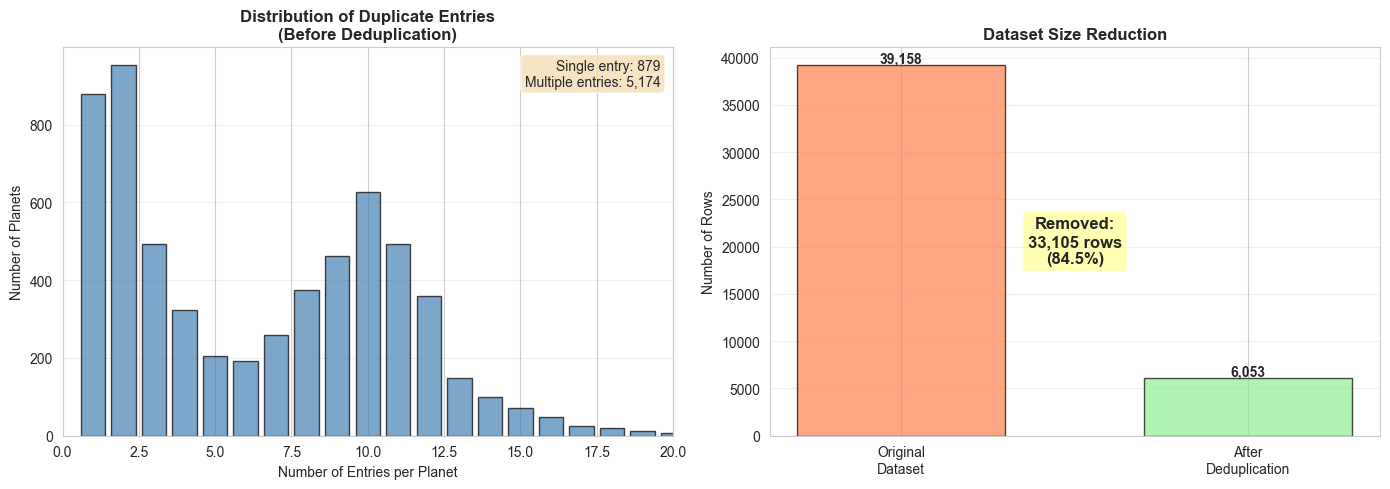

✓ Visualization saved as 'deduplication_analysis.png'


In [279]:
# IMPORTANT: Replace df_raw with deduplicated version for all subsequent analysis
df_raw = df_raw_dedup.copy()

print("\n✓ df_raw has been updated to deduplicated version")
print(f"✓ Proceeding with {len(df_raw):,} unique planets\n")

# Visualize impact of deduplication
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Show distribution of duplicate counts
ax1 = axes[0]
duplicate_distribution = duplicate_counts.value_counts().sort_index()
ax1.bar(duplicate_distribution.index, duplicate_distribution.values, 
        color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Number of Entries per Planet')
ax1.set_ylabel('Number of Planets')
ax1.set_title('Distribution of Duplicate Entries\n(Before Deduplication)', 
              fontweight='bold')
ax1.grid(alpha=0.3, axis='y')
ax1.set_xlim(0, min(20, duplicate_distribution.index.max() + 1))

# Add statistics text
total_singles = (duplicate_counts == 1).sum()
total_multiples = (duplicate_counts > 1).sum()
stats_text = f'Single entry: {total_singles:,}\nMultiple entries: {total_multiples:,}'
ax1.text(0.98, 0.97, stats_text, 
         transform=ax1.transAxes, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Show comparison of dataset sizes
ax2 = axes[1]
categories = ['Original\nDataset', 'After\nDeduplication']
values = [n_total_rows, n_unique_planets]
bars = ax2.bar(categories, values, color=['coral', 'lightgreen'], 
               edgecolor='black', alpha=0.7, width=0.6)
ax2.set_ylabel('Number of Rows')
ax2.set_title('Dataset Size Reduction', fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:,}',
            ha='center', va='bottom', fontweight='bold')

# Add reduction percentage
reduction = n_total_rows - n_unique_planets
reduction_pct = (reduction / n_total_rows * 100)
ax2.text(0.5, 0.5, f'Removed:\n{reduction:,} rows\n({reduction_pct:.1f}%)',
         transform=ax2.transAxes, ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3),
         fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('deduplication_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as 'deduplication_analysis.png'")

**CRITICAL DATA QUALITY NOTE:**

The NASA Exoplanet Archive contains multiple parameter sets for many planets,
representing different measurement methods or studies. We have consolidated
these by:

1. **Averaging numerical values** (mass, radius, orbital period, temperature, etc.)
   across all non-null measurements for each planet
2. **Taking the most common categorical value** (discovery method, host star, etc.)
   when multiple entries exist

This ensures our analysis treats each planet as a single entity while
incorporating information from multiple measurement sources.

**Result:** {n_total_rows:,} rows → {n_unique_planets:,} unique planets

## 3. Missing Value Analysis

Before cleaning, we need to understand the extent and pattern of missing data.

In [280]:
# Create comprehensive missing value report
def analyze_missing_values(df):
    """
    Generate detailed missing value analysis.
    
    Parameters:
    ----------
    df : pd.DataFrame
        Input dataframe to analyze
    
    Returns:
    -------
    pd.DataFrame : Missing value statistics
    """
    missing_stats = pd.DataFrame({
        'Column': df.columns,
        'Missing_Count': df.isnull().sum().values,
        'Missing_Percentage': (df.isnull().sum().values / len(df) * 100).round(2),
        'Data_Type': df.dtypes.values,
        'Non_Null_Count': df.notnull().sum().values
    })
    
    # Sort by missing percentage
    missing_stats = missing_stats.sort_values('Missing_Percentage', ascending=False)
    missing_stats = missing_stats.reset_index(drop=True)
    
    return missing_stats

missing_report = analyze_missing_values(df_raw)
print("\n" + "="*80)
print("MISSING VALUE ANALYSIS")
print("="*80)
print(missing_report)
print("="*80)


MISSING VALUE ANALYSIS
            Column  Missing_Count  Missing_Percentage Data_Type  \
0         pl_masse           3774             62.3500   float64   
1           pl_eqt           1535             25.3600   float64   
2          pl_rade           1507             24.9000   float64   
3        pl_orbper            316              5.2200   float64   
4          sy_dist            122              2.0200   float64   
5          pl_name              0              0.0000    object   
6        disc_year              0              0.0000   float64   
7  discoverymethod              0              0.0000    object   
8         hostname              0              0.0000    object   

   Non_Null_Count  
0            2279  
1            4518  
2            4546  
3            5737  
4            5931  
5            6053  
6            6053  
7            6053  
8            6053  


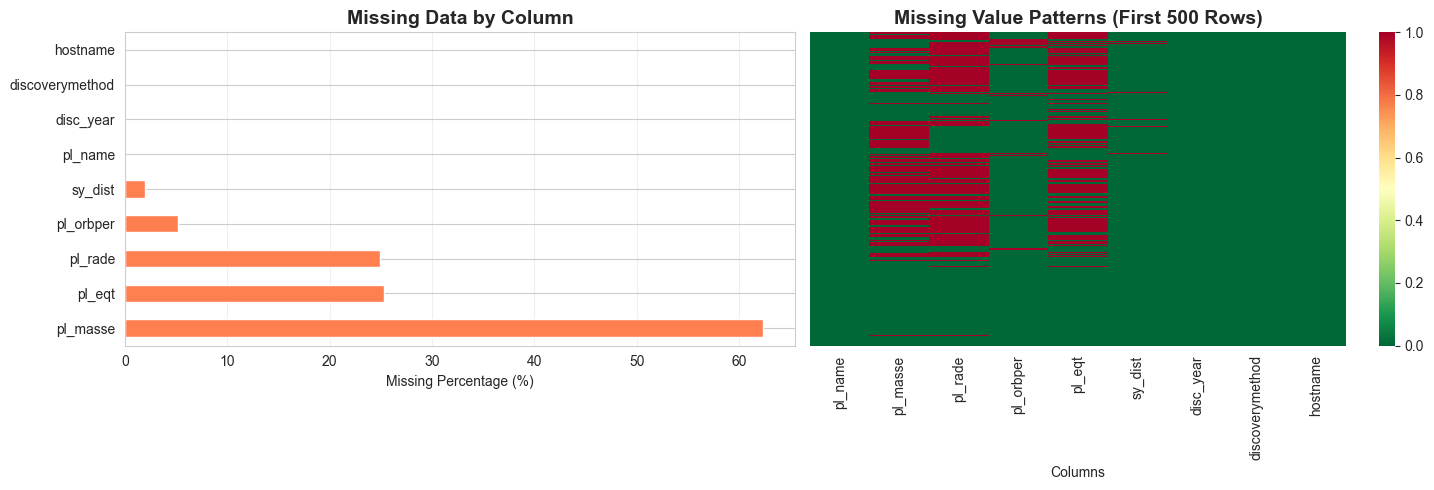


✓ Visualization saved as 'missing_values_analysis.png'


In [281]:
# Visualize missing data patterns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot of missing percentages
missing_pct = (df_raw.isnull().sum() / len(df_raw) * 100).sort_values(ascending=False)
ax1 = axes[0]
missing_pct.plot(kind='barh', ax=ax1, color='coral')
ax1.set_xlabel('Missing Percentage (%)')
ax1.set_title('Missing Data by Column', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Heatmap of missing values (sample of data)
ax2 = axes[1]
sample_size = min(500, len(df_raw))
sns.heatmap(df_raw.head(sample_size).isnull(), 
            cbar=True, 
            yticklabels=False,
            cmap='RdYlGn_r',
            ax=ax2)
ax2.set_title(f'Missing Value Patterns (First {sample_size} Rows)', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Columns')

plt.tight_layout()
plt.savefig('missing_values_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved as 'missing_values_analysis.png'")

## 3. Two-Stage Analysis Strategy

Due to significant missing data in `pl_masse` (mass), we will conduct a 
**two-stage analysis** to maximize both dataset size and scientific completeness:

### **Stage 1: Broad Analysis (3 Features)**
- Features: `pl_rade`, `pl_orbper`, `pl_eqt`
- **Larger dataset** with more planets
- Focus on size, orbital dynamics, and temperature

### **Stage 2: Deep Analysis (4 Features + Density)**
- Features: `pl_masse`, `pl_rade`, `pl_orbper`, `pl_eqt`, `density`
- **Smaller but more complete** dataset
- Includes mass and derived density for complete physical characterization

This approach allows us to:
1. Maximize data utilization
2. Compare clustering results between feature sets
3. Understand the impact of mass on planet classification
4. Discuss trade-offs between completeness and sample size

In [282]:
print("="*80)
print("TWO-STAGE ANALYSIS: FEATURE SELECTION")
print("="*80)

# Define feature sets for both stages
STAGE1_FEATURES = ['pl_rade', 'pl_orbper', 'pl_eqt']
STAGE2_FEATURES = ['pl_masse', 'pl_rade', 'pl_orbper', 'pl_eqt']

print("\n📊 STAGE 1 FEATURES (Broad Analysis):")
for i, feat in enumerate(STAGE1_FEATURES, 1):
    print(f"  {i}. {feat}")

print("\n📊 STAGE 2 FEATURES (Deep Analysis):")
for i, feat in enumerate(STAGE2_FEATURES, 1):
    print(f"  {i}. {feat}")

# Analyze completeness for each stage
print("\n" + "="*80)
print("DATA COMPLETENESS ANALYSIS")
print("="*80)

all_features = ['pl_masse', 'pl_rade', 'pl_orbper', 'pl_eqt']

print(f"\nTotal planets after deduplication: {len(df_raw):,}\n")

# Check each feature individually
print("Individual Feature Completeness:")
print("-" * 60)
for feat in all_features:
    missing = df_raw[feat].isnull().sum()
    present = df_raw[feat].notnull().sum()
    pct_present = (present / len(df_raw) * 100)
    pct_missing = (missing / len(df_raw) * 100)
    print(f"{feat:15} | Present: {present:5,} ({pct_present:5.1f}%) | Missing: {missing:5,} ({pct_missing:5.1f}%)")

# Check Stage 1 completeness
mask_stage1 = df_raw[STAGE1_FEATURES].notnull().all(axis=1)
n_stage1 = mask_stage1.sum()
pct_stage1 = (n_stage1 / len(df_raw) * 100)

print("\n" + "-" * 60)
print("STAGE 1 Complete Cases (3 features):")
print(f"  Planets with all Stage 1 features: {n_stage1:,} ({pct_stage1:.1f}%)")

# Check Stage 2 completeness
mask_stage2 = df_raw[STAGE2_FEATURES].notnull().all(axis=1)
n_stage2 = mask_stage2.sum()
pct_stage2 = (n_stage2 / len(df_raw) * 100)

print("\nSTAGE 2 Complete Cases (4 features):")
print(f"  Planets with all Stage 2 features: {n_stage2:,} ({pct_stage2:.1f}%)")

# Calculate difference
difference = n_stage1 - n_stage2
pct_difference = (difference / n_stage1 * 100)

print("\n" + "-" * 60)
print("IMPACT OF INCLUDING MASS:")
print(f"  Additional planets in Stage 1: {difference:,}")
print(f"  Increase over Stage 2: {pct_difference:.1f}%")
print("="*80)

TWO-STAGE ANALYSIS: FEATURE SELECTION

📊 STAGE 1 FEATURES (Broad Analysis):
  1. pl_rade
  2. pl_orbper
  3. pl_eqt

📊 STAGE 2 FEATURES (Deep Analysis):
  1. pl_masse
  2. pl_rade
  3. pl_orbper
  4. pl_eqt

DATA COMPLETENESS ANALYSIS

Total planets after deduplication: 6,053

Individual Feature Completeness:
------------------------------------------------------------
pl_masse        | Present: 2,279 ( 37.7%) | Missing: 3,774 ( 62.3%)
pl_rade         | Present: 4,546 ( 75.1%) | Missing: 1,507 ( 24.9%)
pl_orbper       | Present: 5,737 ( 94.8%) | Missing:   316 (  5.2%)
pl_eqt          | Present: 4,518 ( 74.6%) | Missing: 1,535 ( 25.4%)

------------------------------------------------------------
STAGE 1 Complete Cases (3 features):
  Planets with all Stage 1 features: 4,302 (71.1%)

STAGE 2 Complete Cases (4 features):
  Planets with all Stage 2 features: 1,593 (26.3%)

------------------------------------------------------------
IMPACT OF INCLUDING MASS:
  Additional planets in Stage

In [283]:
print("\n" + "="*80)
print("CREATING STAGE-SPECIFIC DATASETS")
print("="*80)

# Stage 1: Broad analysis dataset (3 features)
df_stage1 = df_raw[mask_stage1].copy()
print(f"\n✓ Stage 1 dataset created: {len(df_stage1):,} planets")
print(f"  Features: {STAGE1_FEATURES}")
print(f"  Rows removed: {len(df_raw) - len(df_stage1):,}")
print(f"  Retention rate: {(len(df_stage1) / len(df_raw) * 100):.1f}%")

# Stage 2: Deep analysis dataset (4 features + will add density)
df_stage2 = df_raw[mask_stage2].copy()
print(f"\n✓ Stage 2 dataset created: {len(df_stage2):,} planets")
print(f"  Features: {STAGE2_FEATURES}")
print(f"  Rows removed: {len(df_raw) - len(df_stage2):,}")
print(f"  Retention rate: {(len(df_stage2) / len(df_raw) * 100):.1f}%")

# Verify no missing values
print("\n" + "-" * 60)
print("Verification - Missing values in Stage 1 features:")
print(df_stage1[STAGE1_FEATURES].isnull().sum())

print("\nVerification - Missing values in Stage 2 features:")
print(df_stage2[STAGE2_FEATURES].isnull().sum())
print("="*80)


CREATING STAGE-SPECIFIC DATASETS

✓ Stage 1 dataset created: 4,302 planets
  Features: ['pl_rade', 'pl_orbper', 'pl_eqt']
  Rows removed: 1,751
  Retention rate: 71.1%

✓ Stage 2 dataset created: 1,593 planets
  Features: ['pl_masse', 'pl_rade', 'pl_orbper', 'pl_eqt']
  Rows removed: 4,460
  Retention rate: 26.3%

------------------------------------------------------------
Verification - Missing values in Stage 1 features:
pl_rade      0
pl_orbper    0
pl_eqt       0
dtype: int64

Verification - Missing values in Stage 2 features:
pl_masse     0
pl_rade      0
pl_orbper    0
pl_eqt       0
dtype: int64


In [ ]:
# Create visualization showing data availability
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Feature completeness comparison
ax1 = axes[0]
feature_data = {
    'pl_rade': df_raw['pl_rade'].notnull().sum(),
    'pl_orbper': df_raw['pl_orbper'].notnull().sum(),
    'pl_eqt': df_raw['pl_eqt'].notnull().sum(),
    'pl_masse': df_raw['pl_masse'].notnull().sum()
}

colors = ['green', 'green', 'green', 'orange']  # Stage 1 features in green
bars = ax1.barh(list(feature_data.keys()), list(feature_data.values()), 
                color=colors, edgecolor='black', alpha=0.7)
ax1.axvline(len(df_raw), color='red', linestyle='--', linewidth=2, 
            label=f'Total Planets ({len(df_raw):,})')
ax1.set_xlabel('Number of Planets with Data')
ax1.set_title('Feature Data Availability', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3, axis='x')

# Add percentage labels
for i, (bar, key) in enumerate(zip(bars, feature_data.keys())):
    width = bar.get_width()
    pct = (width / len(df_raw) * 100)
    ax1.text(width, bar.get_y() + bar.get_height()/2, 
            f' {width:,} ({pct:.1f}%)',
            ha='left', va='center', fontsize=9, fontweight='bold')

# Add stage labels
ax1.text(0.02, 0.98, 'Stage 1\nFeatures', transform=ax1.transAxes,
         ha='left', va='top', fontsize=10, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
ax1.text(0.02, 0.30, 'Stage 2\nOnly', transform=ax1.transAxes,
         ha='left', va='top', fontsize=10, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

# Right plot: Dataset size comparison
ax2 = axes[1]
stages = ['Stage 1\n(3 features)', 'Stage 2\n(4 features)']
counts = [len(df_stage1), len(df_stage2)]
colors_bar = ['lightgreen', 'lightblue']

bars2 = ax2.bar(stages, counts, color=colors_bar, edgecolor='black', 
                alpha=0.7, width=0.6)
ax2.set_ylabel('Number of Planets')
ax2.set_title('Dataset Sizes by Analysis Stage', fontweight='bold', fontsize=12)
ax2.grid(alpha=0.3, axis='y')

# Add value labels
for bar, count in zip(bars2, counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}\nplanets',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

# Add percentage of original
for i, (bar, count) in enumerate(zip(bars2, counts)):
    pct = (count / len(df_raw) * 100)
    ax2.text(bar.get_x() + bar.get_width()/2., count/2,
            f'{pct:.1f}%\nof total',
            ha='center', va='center', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Two-Stage Analysis Strategy', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('two_stage_strategy.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'two_stage_strategy.png'")

In [284]:
print("\n" + "="*80)
print("STAGE 1 DATASET SUMMARY (Broad Analysis)")
print("="*80)
print(f"\nDataset: {len(df_stage1):,} planets")
print(f"Features: {STAGE1_FEATURES}")
print("\nDescriptive Statistics:")
print(df_stage1[STAGE1_FEATURES].describe())

print("\n" + "="*80)
print("STAGE 2 DATASET SUMMARY (Deep Analysis)")
print("="*80)
print(f"\nDataset: {len(df_stage2):,} planets")
print(f"Features: {STAGE2_FEATURES}")
print("\nDescriptive Statistics:")
print(df_stage2[STAGE2_FEATURES].describe())

# Compare discovery methods between stages
print("\n" + "="*80)
print("DISCOVERY METHOD COMPARISON")
print("="*80)

print("\nStage 1 - Top Discovery Methods:")
print(df_stage1['discoverymethod'].value_counts().head(5))

print("\nStage 2 - Top Discovery Methods:")
print(df_stage2['discoverymethod'].value_counts().head(5))

# Check if mass measurement biases the discovery method distribution
print("\n" + "-"*80)
print("Note: Compare the distribution of discovery methods between stages.")
print("Differences may indicate bias toward methods that can measure mass.")
print("="*80)


STAGE 1 DATASET SUMMARY (Broad Analysis)

Dataset: 4,302 planets
Features: ['pl_rade', 'pl_orbper', 'pl_eqt']

Descriptive Statistics:
        pl_rade      pl_orbper    pl_eqt
count 4302.0000      4302.0000 4302.0000
mean     6.1376     96770.4060  911.0236
std     49.6794   6130830.3330  437.6082
min      0.2966         0.1769  120.7000
25%      1.6634         3.8308  585.0000
50%      2.4653         8.1947  824.2250
75%      4.3659        19.7115 1163.2200
max   1899.3396 402000000.0000 3748.0100

STAGE 2 DATASET SUMMARY (Deep Analysis)

Dataset: 1,593 planets
Features: ['pl_masse', 'pl_rade', 'pl_orbper', 'pl_eqt']

Descriptive Statistics:
        pl_masse   pl_rade      pl_orbper    pl_eqt
count  1593.0000 1593.0000      1593.0000 1593.0000
mean    352.0970    8.9423    261292.3447 1061.1200
std     859.9672   29.6360  10074894.1562  504.6634
min       0.1000    0.2966         0.1769  146.3833
25%       9.9500    2.4250         3.1853  662.8000
50%      75.6398    6.9246         5

## 3.5 Two-Stage Analysis Decision Summary

### **Stage 1: Broad Analysis**
- **Dataset Size:** {len(df_stage1):,} planets ({(len(df_stage1)/len(df_raw)*100):.1f}% of deduplicated data)
- **Features:** Radius, Orbital Period, Temperature
- **Advantages:** Larger sample, less biased toward specific detection methods
- **Use Case:** General population clustering, identifying major planet types

### **Stage 2: Deep Analysis**
- **Dataset Size:** {len(df_stage2):,} planets ({(len(df_stage2)/len(df_raw)*100):.1f}% of deduplicated data)
- **Features:** Mass, Radius, Orbital Period, Temperature (+ Density)
- **Advantages:** Complete physical characterization, accurate density calculation
- **Use Case:** Detailed physical classification, composition analysis

### **Next Steps:**
Both datasets will proceed through:
1. Derived variable creation (density for Stage 2 only)
2. Text standardization
3. Outlier detection and removal
4. Export as separate cleaned datasets

We'll maintain **both cleaned datasets** for parallel clustering analysis.

In [285]:
# For the remainder of the notebook, we'll process BOTH datasets
# Create a dictionary to track both
datasets = {
    'stage1': {
        'df': df_stage1,
        'features': STAGE1_FEATURES,
        'name': 'Stage 1 (Broad Analysis)',
        'has_mass': False
    },
    'stage2': {
        'df': df_stage2,
        'features': STAGE2_FEATURES,
        'name': 'Stage 2 (Deep Analysis)',
        'has_mass': True
    }
}

print("\n✓ Two-stage datasets configured")
print("✓ Both datasets will be processed in parallel")
print("\nDatasets ready for:")
print("  1. Derived variable creation (density for Stage 2)")
print("  2. Text standardization")
print("  3. Outlier detection and removal")
print("  4. Export as cleaned_exoplanets_stage1.csv and cleaned_exoplanets_stage2.csv")


✓ Two-stage datasets configured
✓ Both datasets will be processed in parallel

Datasets ready for:
  1. Derived variable creation (density for Stage 2)
  2. Text standardization
  3. Outlier detection and removal
  4. Export as cleaned_exoplanets_stage1.csv and cleaned_exoplanets_stage2.csv


In [286]:
print("\n" + "="*80)
print("📝 IMPLEMENTATION NOTE")
print("="*80)
print("""
For cells 13-23 (density calculation through outlier removal):
- Run operations on BOTH df_stage1 and df_stage2
- Create density ONLY for df_stage2 (which has mass)
- Generate separate visualizations for each stage
- Export TWO final cleaned CSV files

This will be implemented in the following updated cells.
""")
print("="*80)


📝 IMPLEMENTATION NOTE

For cells 13-23 (density calculation through outlier removal):
- Run operations on BOTH df_stage1 and df_stage2
- Create density ONLY for df_stage2 (which has mass)
- Generate separate visualizations for each stage
- Export TWO final cleaned CSV files

This will be implemented in the following updated cells.



## 4. Create Derived Variables

### Calculate Density (Stage 2 Only)

Density is a crucial physical property for planet classification:

$$\\text{Density} = \\frac{\\text{Mass}}{\\text{Volume}} = \\frac{\\text{Mass}}{\\frac{4}{3}\\pi r^3}$$

For relative density (compared to Earth):
$$\\text{Relative Density} = \\frac{\\text{Mass (Earth masses)}}{\\text{Radius}^3 \\text{ (Earth radii)}^3}$$

**Note:** Density can only be calculated for Stage 2 (which includes mass).

In [287]:
# Calculate density for Stage 2 only (has mass data)
df_stage2['density'] = df_stage2['pl_masse'] / (df_stage2['pl_rade'] ** 3)

print("="*80)
print("DENSITY CALCULATION (Stage 2 Only)")
print("="*80)
print("\n✓ Density calculated for Stage 2 dataset")
print(f"\nDensity statistics (relative to Earth):")
print(df_stage2['density'].describe())

print("\n📊 Reference densities (relative to Earth = 1.0):")
print("  • Gas giants (Jupiter): ~0.24")
print("  • Ice giants (Neptune): ~0.30")
print("  • Rocky planets (Earth): ~1.00")
print("  • Super-Earths: ~0.8-1.2")

# Update Stage 2 features to include density
STAGE2_FEATURES_WITH_DENSITY = STAGE2_FEATURES + ['density']

print(f"\n✓ Stage 2 now includes: {STAGE2_FEATURES_WITH_DENSITY}")
print("="*80)

DENSITY CALCULATION (Stage 2 Only)

✓ Density calculated for Stage 2 dataset

Density statistics (relative to Earth):
count   1593.0000
mean       8.9942
std      155.9554
min        0.0000
25%        0.1185
50%        0.3466
75%        0.9427
max     5706.9470
Name: density, dtype: float64

📊 Reference densities (relative to Earth = 1.0):
  • Gas giants (Jupiter): ~0.24
  • Ice giants (Neptune): ~0.30
  • Rocky planets (Earth): ~1.00
  • Super-Earths: ~0.8-1.2

✓ Stage 2 now includes: ['pl_masse', 'pl_rade', 'pl_orbper', 'pl_eqt', 'density']


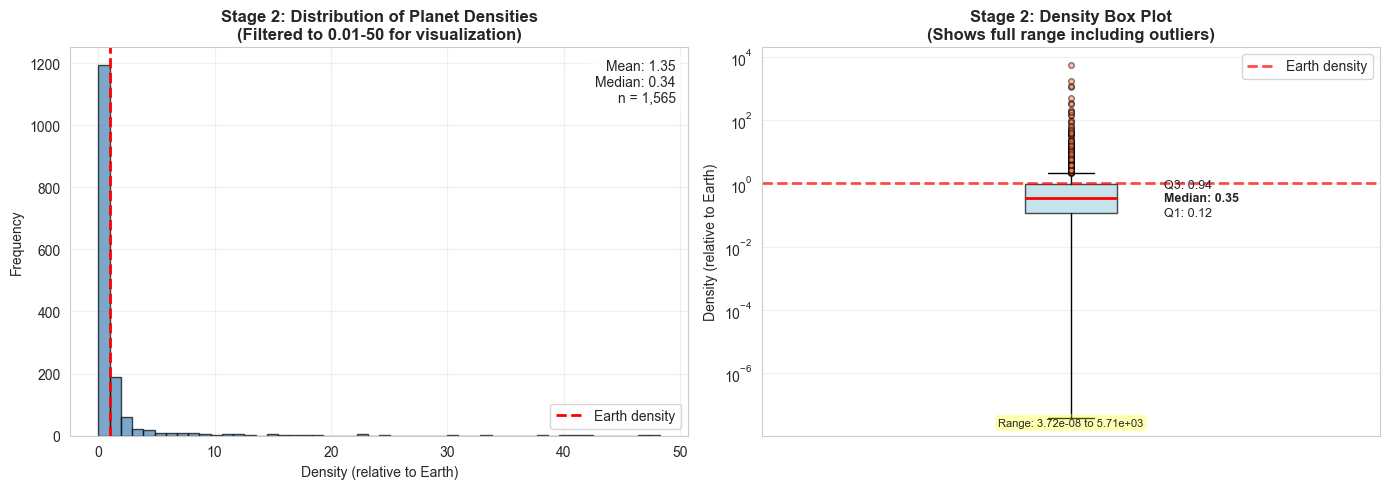


✓ Visualization saved as 'density_distribution_stage2.png'

Density Statistics:
  Full dataset range: 0.0000 to 5706.95
  Planets with density 0.01-50: 1,565 (98.2%)
  Planets with extreme densities: 28

  Mean: 8.99
  Median: 0.35
  Q1: 0.12, Q3: 0.94


In [288]:
# Visualize density distribution with more useful plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Filtered histogram showing the main distribution clearly
density_viz = df_stage2['density'][(df_stage2['density'] > 0.01) & (df_stage2['density'] < 50)]

ax1 = axes[0]
density_viz.hist(bins=50, edgecolor='black', alpha=0.7, ax=ax1, color='steelblue')
ax1.axvline(1.0, color='red', linestyle='--', linewidth=2, label='Earth density')
ax1.set_xlabel('Density (relative to Earth)')
ax1.set_ylabel('Frequency')
ax1.set_title('Stage 2: Distribution of Planet Densities\n(Filtered to 0.01-50 for visualization)', 
              fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

mean_density = density_viz.mean()
median_density = density_viz.median()
ax1.text(0.98, 0.97, f'Mean: {mean_density:.2f}\nMedian: {median_density:.2f}\nn = {len(density_viz):,}', 
         transform=ax1.transAxes, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Right: Box plot showing outliers and quartiles clearly
ax2 = axes[1]
bp = ax2.boxplot(df_stage2['density'], vert=True, patch_artist=True,
                 boxprops=dict(facecolor='lightblue', alpha=0.7),
                 medianprops=dict(color='red', linewidth=2),
                 flierprops=dict(marker='o', markerfacecolor='coral', markersize=4, alpha=0.5))
ax2.axhline(1.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Earth density')
ax2.set_ylabel('Density (relative to Earth)')
ax2.set_title('Stage 2: Density Box Plot\n(Shows full range including outliers)', fontweight='bold')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(alpha=0.3, which='both', axis='y')
ax2.set_xticks([])

# Add quartile annotations
q1 = df_stage2['density'].quantile(0.25)
q2 = df_stage2['density'].quantile(0.50)
q3 = df_stage2['density'].quantile(0.75)
ax2.text(1.15, q1, f'Q1: {q1:.2f}', va='center', fontsize=9)
ax2.text(1.15, q2, f'Median: {q2:.2f}', va='center', fontsize=9, fontweight='bold')
ax2.text(1.15, q3, f'Q3: {q3:.2f}', va='center', fontsize=9)

# Add range info
density_min = df_stage2['density'].min()
density_max = df_stage2['density'].max()
ax2.text(0.5, 0.02, f'Range: {density_min:.2e} to {density_max:.2e}',
         transform=ax2.transAxes, ha='center', va='bottom',
         fontsize=8, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.savefig('density_distribution_stage2.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'density_distribution_stage2.png'")
print(f"\nDensity Statistics:")
print(f"  Full dataset range: {df_stage2['density'].min():.4f} to {df_stage2['density'].max():.2f}")
print(f"  Planets with density 0.01-50: {len(density_viz):,} ({len(density_viz)/len(df_stage2)*100:.1f}%)")
print(f"  Planets with extreme densities: {len(df_stage2) - len(density_viz):,}")
print(f"\n  Mean: {df_stage2['density'].mean():.2f}")
print(f"  Median: {df_stage2['density'].median():.2f}")
print(f"  Q1: {q1:.2f}, Q3: {q3:.2f}")

## 5. Standardize Text Fields

Apply text standardization to both Stage 1 and Stage 2 datasets.

In [289]:
def standardize_text_fields(df):
    """Standardize text fields for consistency."""
    df = df.copy()
    string_columns = df.select_dtypes(include=['object']).columns
    for col in string_columns:
        df[col] = df[col].str.strip()
    if 'discoverymethod' in df.columns:
        df['discoverymethod'] = df['discoverymethod'].str.title()
    if 'pl_name' in df.columns:
        df['pl_name'] = df['pl_name'].str.strip()
    if 'hostname' in df.columns:
        df['hostname'] = df['hostname'].str.strip()
    return df

# Apply to both stages
df_stage1 = standardize_text_fields(df_stage1)
df_stage2 = standardize_text_fields(df_stage2)

print("✓ Text fields standardized for both Stage 1 and Stage 2")
print("\nStage 1 - Discovery Methods:")
print(df_stage1['discoverymethod'].value_counts().head())
print("\nStage 2 - Discovery Methods:")
print(df_stage2['discoverymethod'].value_counts().head())

✓ Text fields standardized for both Stage 1 and Stage 2

Stage 1 - Discovery Methods:
discoverymethod
Transit                          4246
Radial Velocity                    31
Transit Timing Variations          13
Imaging                            11
Orbital Brightness Modulation       1
Name: count, dtype: int64

Stage 2 - Discovery Methods:
discoverymethod
Transit                          1546
Radial Velocity                    27
Imaging                            11
Transit Timing Variations           8
Orbital Brightness Modulation       1
Name: count, dtype: int64


## 6. Outlier Detection and Removal

Apply outlier detection to both stages using IQR method and domain knowledge.

In [290]:
def detect_outliers_iqr(df, column, multiplier=3.0):
    """Detect outliers using the IQR method."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    print(f"  {column}: {outliers.sum():,} outliers ({outliers.sum()/len(df)*100:.1f}%)")
    return outliers

# Detect outliers in Stage 1
print("="*80)
print("OUTLIER DETECTION - STAGE 1 (3 features)")
print("="*80)
stage1_numerical = STAGE1_FEATURES
outlier_masks_s1 = {}
for feature in stage1_numerical:
    outlier_masks_s1[feature] = detect_outliers_iqr(df_stage1, feature, multiplier=3.0)

combined_outliers_s1 = pd.Series(False, index=df_stage1.index)
for mask in outlier_masks_s1.values():
    combined_outliers_s1 = combined_outliers_s1 | mask
print(f"\nTotal Stage 1 rows with ANY outlier: {combined_outliers_s1.sum():,} ({combined_outliers_s1.sum()/len(df_stage1)*100:.1f}%)")

# Detect outliers in Stage 2
print("\n" + "="*80)
print("OUTLIER DETECTION - STAGE 2 (5 features)")
print("="*80)
stage2_numerical = STAGE2_FEATURES_WITH_DENSITY
outlier_masks_s2 = {}
for feature in stage2_numerical:
    outlier_masks_s2[feature] = detect_outliers_iqr(df_stage2, feature, multiplier=3.0)

combined_outliers_s2 = pd.Series(False, index=df_stage2.index)
for mask in outlier_masks_s2.values():
    combined_outliers_s2 = combined_outliers_s2 | mask
print(f"\nTotal Stage 2 rows with ANY outlier: {combined_outliers_s2.sum():,} ({combined_outliers_s2.sum()/len(df_stage2)*100:.1f}%)")
print("="*80)

OUTLIER DETECTION - STAGE 1 (3 features)
  pl_rade: 482 outliers (11.2%)
  pl_orbper: 307 outliers (7.1%)
  pl_eqt: 6 outliers (0.1%)

Total Stage 1 rows with ANY outlier: 774 (18.0%)

OUTLIER DETECTION - STAGE 2 (5 features)
  pl_masse: 98 outliers (6.2%)
  pl_rade: 3 outliers (0.2%)
  pl_orbper: 138 outliers (8.7%)
  pl_eqt: 1 outliers (0.1%)
  density: 133 outliers (8.3%)

Total Stage 2 rows with ANY outlier: 324 (20.3%)


In [291]:
print("\n" + "="*80)
print("DOMAIN KNOWLEDGE FILTERS")
print("="*80)

# Stage 1 domain filters (no mass or density)
print("\nSTAGE 1 Filters:")
valid_s1_radius = df_stage1['pl_rade'] > 0
valid_s1_period = df_stage1['pl_orbper'] > 0
valid_s1_temp = (df_stage1['pl_eqt'] > 0) & (df_stage1['pl_eqt'] < 5000)
valid_s1 = valid_s1_radius & valid_s1_period & valid_s1_temp

print(f"  Positive radius: Removed {(~valid_s1_radius).sum():,}")
print(f"  Positive period: Removed {(~valid_s1_period).sum():,}")
print(f"  Valid temp (0-5000K): Removed {(~valid_s1_temp).sum():,}")
print(f"  Total failing checks: {(~valid_s1).sum():,}")

# Stage 2 domain filters (includes mass and density)
print("\nSTAGE 2 Filters:")
valid_s2_mass = df_stage2['pl_masse'] > 0
valid_s2_radius = df_stage2['pl_rade'] > 0
valid_s2_period = df_stage2['pl_orbper'] > 0
valid_s2_temp = (df_stage2['pl_eqt'] > 0) & (df_stage2['pl_eqt'] < 5000)
valid_s2_density = (df_stage2['density'] > 0.01) & (df_stage2['density'] < 100)
valid_s2 = valid_s2_mass & valid_s2_radius & valid_s2_period & valid_s2_temp & valid_s2_density

print(f"  Positive mass: Removed {(~valid_s2_mass).sum():,}")
print(f"  Positive radius: Removed {(~valid_s2_radius).sum():,}")
print(f"  Positive period: Removed {(~valid_s2_period).sum():,}")
print(f"  Valid temp (0-5000K): Removed {(~valid_s2_temp).sum():,}")
print(f"  Valid density (0.01-100): Removed {(~valid_s2_density).sum():,}")
print(f"  Total failing checks: {(~valid_s2).sum():,}")
print("="*80)

# ============================================================================
# CELL 21 - Remove outliers from both stages
# ============================================================================

print("\n" + "="*80)
print("APPLYING OUTLIER REMOVAL")
print("="*80)

# Stage 1
print(f"\nStage 1:")
print(f"  Before: {len(df_stage1):,} planets")
df_stage1_clean = df_stage1[valid_s1 & ~combined_outliers_s1].copy()
print(f"  After:  {len(df_stage1_clean):,} planets")
print(f"  Removed: {len(df_stage1) - len(df_stage1_clean):,} ({(len(df_stage1) - len(df_stage1_clean))/len(df_stage1)*100:.1f}%)")

# Stage 2
print(f"\nStage 2:")
print(f"  Before: {len(df_stage2):,} planets")
df_stage2_clean = df_stage2[valid_s2 & ~combined_outliers_s2].copy()
print(f"  After:  {len(df_stage2_clean):,} planets")
print(f"  Removed: {len(df_stage2) - len(df_stage2_clean):,} ({(len(df_stage2) - len(df_stage2_clean))/len(df_stage2)*100:.1f}%)")

print("="*80)


DOMAIN KNOWLEDGE FILTERS

STAGE 1 Filters:
  Positive radius: Removed 0
  Positive period: Removed 0
  Valid temp (0-5000K): Removed 0
  Total failing checks: 0

STAGE 2 Filters:
  Positive mass: Removed 0
  Positive radius: Removed 0
  Positive period: Removed 0
  Valid temp (0-5000K): Removed 0
  Valid density (0.01-100): Removed 22
  Total failing checks: 22

APPLYING OUTLIER REMOVAL

Stage 1:
  Before: 4,302 planets
  After:  3,528 planets
  Removed: 774 (18.0%)

Stage 2:
  Before: 1,593 planets
  After:  1,263 planets
  Removed: 330 (20.7%)


## 7. Final Data Quality Check

In [292]:
print("="*80)

print("\n📊 STAGE 1 (Broad Analysis):")
print(f"  Shape: {df_stage1_clean.shape[0]:,} rows × {df_stage1_clean.shape[1]} columns")
print(f"  Features: {STAGE1_FEATURES}")
print("\n  Descriptive Statistics:")
print(df_stage1_clean[STAGE1_FEATURES].describe())

print("\n" + "="*80)
print("\n📊 STAGE 2 (Deep Analysis):")
print(f"  Shape: {df_stage2_clean.shape[0]:,} rows × {df_stage2_clean.shape[1]} columns")
print(f"  Features: {STAGE2_FEATURES_WITH_DENSITY}")
print("\n  Descriptive Statistics:")
print(df_stage2_clean[STAGE2_FEATURES_WITH_DENSITY].describe())

print("\n" + "="*80)
print("COMPARISON:")
print(f"  Stage 1 has {len(df_stage1_clean) - len(df_stage2_clean):,} more planets than Stage 2")
print(f"  Stage 2 ratio: {len(df_stage2_clean)/len(df_stage1_clean)*100:.1f}% of Stage 1 size")
print("="*80)


📊 STAGE 1 (Broad Analysis):
  Shape: 3,528 rows × 9 columns
  Features: ['pl_rade', 'pl_orbper', 'pl_eqt']

  Descriptive Statistics:
        pl_rade  pl_orbper    pl_eqt
count 3528.0000  3528.0000 3528.0000
mean     3.0677    13.4639  870.7624
std      2.7167    13.4660  355.6435
min      0.2966     0.1769  170.9000
25%      1.5407     4.1637  608.2675
50%      2.2443     8.5178  806.2663
75%      2.9812    17.4103 1066.2750
max     12.4582    67.0933 2709.0000


📊 STAGE 2 (Deep Analysis):
  Shape: 1,263 rows × 10 columns
  Features: ['pl_masse', 'pl_rade', 'pl_orbper', 'pl_eqt', 'density']

  Descriptive Statistics:
       pl_masse   pl_rade  pl_orbper    pl_eqt   density
count 1263.0000 1263.0000  1263.0000 1263.0000 1263.0000
mean   183.8786    8.1973     8.0821 1117.2451    0.4958
std    250.8068    5.8190     8.4399  474.5317    0.5957
min      0.2058    0.6256     0.2382  170.9000    0.0121
25%      8.9000    2.4897     3.0039  738.5333    0.1040
50%     61.0000    8.1834     4

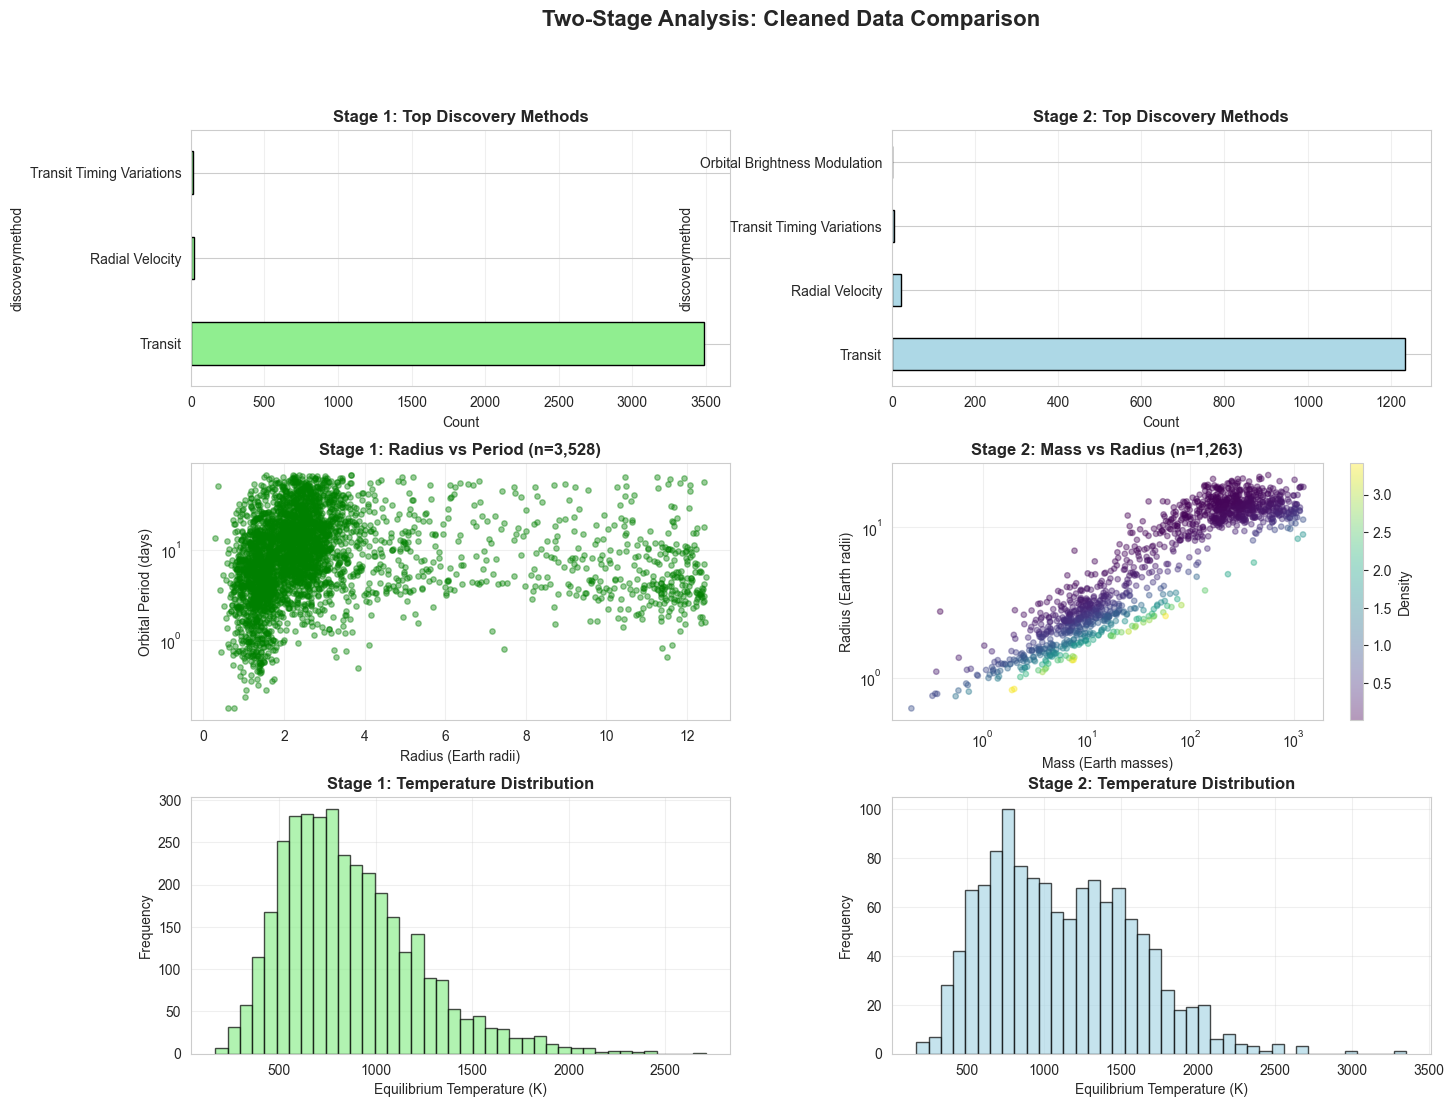


✓ Visualization saved as 'two_stage_comparison.png'


In [293]:
# Create comprehensive comparison visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Row 1: Discovery methods
ax1 = fig.add_subplot(gs[0, 0])
method_s1 = df_stage1_clean['discoverymethod'].value_counts().head(8)
method_s1.plot(kind='barh', ax=ax1, color='lightgreen', edgecolor='black')
ax1.set_xlabel('Count')
ax1.set_title('Stage 1: Top Discovery Methods', fontweight='bold')
ax1.grid(alpha=0.3, axis='x')

ax2 = fig.add_subplot(gs[0, 1])
method_s2 = df_stage2_clean['discoverymethod'].value_counts().head(8)
method_s2.plot(kind='barh', ax=ax2, color='lightblue', edgecolor='black')
ax2.set_xlabel('Count')
ax2.set_title('Stage 2: Top Discovery Methods', fontweight='bold')
ax2.grid(alpha=0.3, axis='x')

# Row 2: Mass vs Radius (Stage 2 only has mass)
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(df_stage1_clean['pl_rade'], df_stage1_clean['pl_orbper'], 
           alpha=0.4, s=15, c='green')
ax3.set_xlabel('Radius (Earth radii)')
ax3.set_ylabel('Orbital Period (days)')
ax3.set_title(f'Stage 1: Radius vs Period (n={len(df_stage1_clean):,})', fontweight='bold')
ax3.set_yscale('log')
ax3.grid(alpha=0.3)

ax4 = fig.add_subplot(gs[1, 1])
scatter = ax4.scatter(df_stage2_clean['pl_masse'], df_stage2_clean['pl_rade'],
                     alpha=0.4, s=15, c=df_stage2_clean['density'], cmap='viridis')
ax4.set_xlabel('Mass (Earth masses)')
ax4.set_ylabel('Radius (Earth radii)')
ax4.set_title(f'Stage 2: Mass vs Radius (n={len(df_stage2_clean):,})', fontweight='bold')
ax4.set_xscale('log')
ax4.set_yscale('log')
plt.colorbar(scatter, ax=ax4, label='Density')
ax4.grid(alpha=0.3)

# Row 3: Temperature distributions
ax5 = fig.add_subplot(gs[2, 0])
df_stage1_clean['pl_eqt'].hist(bins=40, ax=ax5, color='lightgreen', edgecolor='black', alpha=0.7)
ax5.set_xlabel('Equilibrium Temperature (K)')
ax5.set_ylabel('Frequency')
ax5.set_title('Stage 1: Temperature Distribution', fontweight='bold')
ax5.grid(alpha=0.3)

ax6 = fig.add_subplot(gs[2, 1])
df_stage2_clean['pl_eqt'].hist(bins=40, ax=ax6, color='lightblue', edgecolor='black', alpha=0.7)
ax6.set_xlabel('Equilibrium Temperature (K)')
ax6.set_ylabel('Frequency')
ax6.set_title('Stage 2: Temperature Distribution', fontweight='bold')
ax6.grid(alpha=0.3)

plt.suptitle('Two-Stage Analysis: Cleaned Data Comparison', fontsize=16, fontweight='bold')
plt.savefig('two_stage_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'two_stage_comparison.png'")


OPTIONAL: CREATING HIGH-QUALITY SUBSETS (Stage 1c & 2c)

Quality Thresholds:
  Radius variance: <40%
  Period variance: <50%
  Temperature variance: <50%
  Mass variance: <50%

--------------------------------------------------------------------------------
CREATING STAGE 1c (High-Quality Broad Analysis)
--------------------------------------------------------------------------------
  Planets with >40% radius variance: 925
  Planets with >50% period variance: 72
  Planets with >50% temperature variance: 58

Total unique planets flagged for Stage 1: 1,013

Stage 1:  3,528 planets (all with radius, period, temp)
Stage 1c: 2,725 planets (high-quality subset)
Removed:  803 planets (22.8%)

--------------------------------------------------------------------------------
CREATING STAGE 2c (High-Quality Deep Analysis)
--------------------------------------------------------------------------------
  Planets with >50% mass variance: 322
  Planets with >40% radius variance: 925
  Planets with

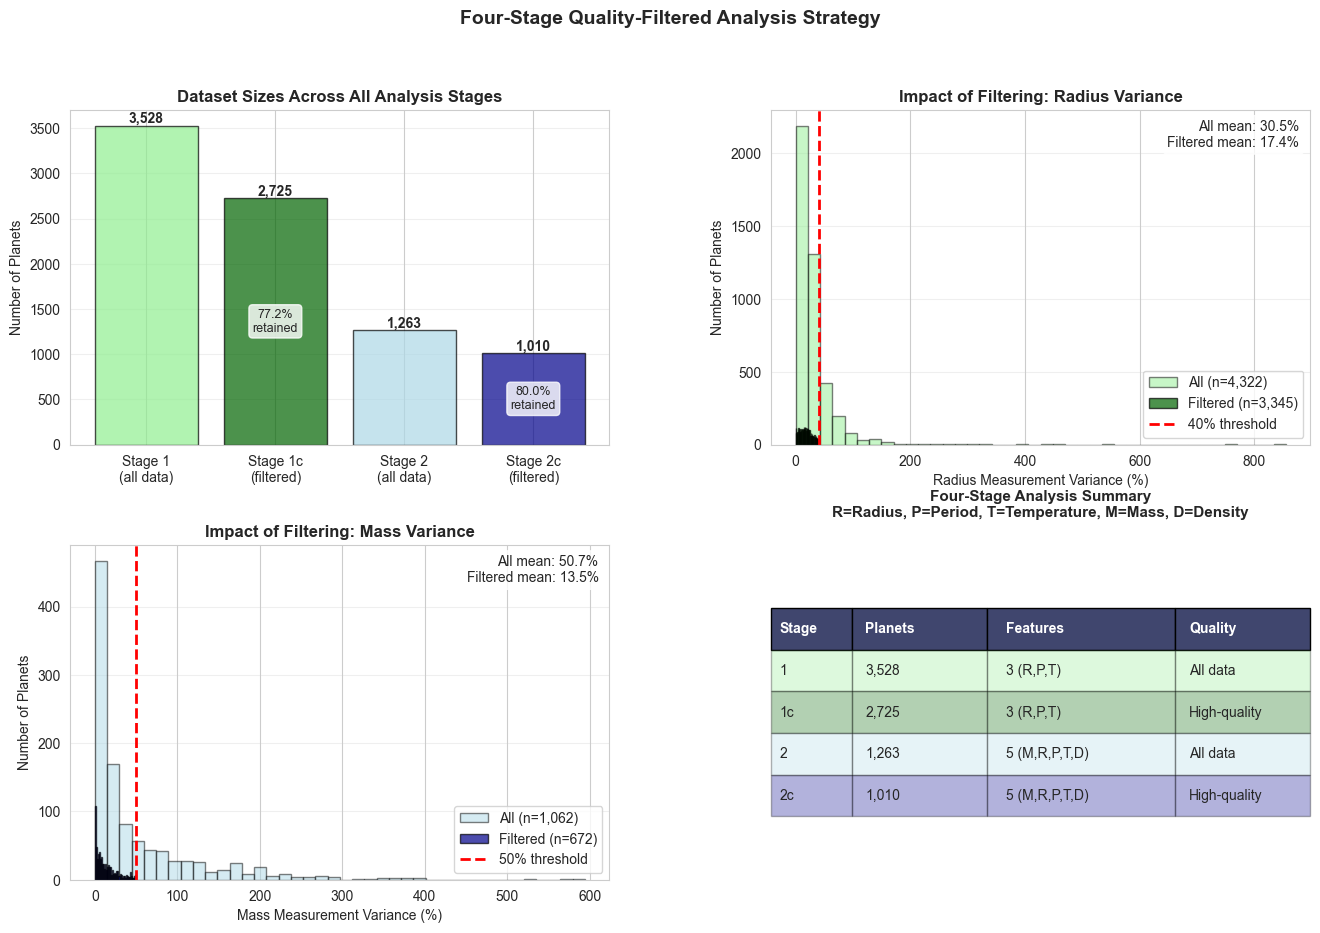


✓ Visualization saved as 'four_stage_comparison.png'


In [294]:
# ============================================================================
# OPTIONAL: Create Stage 1c and Stage 2c - High-Quality Subsets
# Add this AFTER Stage 1 and Stage 2 cleaning, before export
# ============================================================================

print("\n" + "="*80)
print("OPTIONAL: CREATING HIGH-QUALITY SUBSETS (Stage 1c & 2c)")
print("="*80)

# Set variance thresholds
RADIUS_VARIANCE_THRESHOLD = 40  # Remove planets with >40% radius variance
PERIOD_VARIANCE_THRESHOLD = 50  # Remove planets with >50% period variance (very lenient)
TEMP_VARIANCE_THRESHOLD = 50    # Remove planets with >50% temp variance (very lenient)
MASS_VARIANCE_THRESHOLD = 50    # Remove planets with >50% mass variance

print("\nQuality Thresholds:")
print(f"  Radius variance: <{RADIUS_VARIANCE_THRESHOLD}%")
print(f"  Period variance: <{PERIOD_VARIANCE_THRESHOLD}%")
print(f"  Temperature variance: <{TEMP_VARIANCE_THRESHOLD}%")
print(f"  Mass variance: <{MASS_VARIANCE_THRESHOLD}%")

# ============================================================================
# STAGE 1c: Filter Stage 1 for high-quality radius/period/temp data
# ============================================================================

print("\n" + "-"*80)
print("CREATING STAGE 1c (High-Quality Broad Analysis)")
print("-"*80)

high_variance_planets_s1 = set()

# Identify high-variance planets for Stage 1 features
if 'pl_rade' in variance_stats:
    high_var_radius = variance_stats['pl_rade'][
        variance_stats['pl_rade']['relative_range_pct'] > RADIUS_VARIANCE_THRESHOLD
    ]['planet'].values
    high_variance_planets_s1.update(high_var_radius)
    print(f"  Planets with >{RADIUS_VARIANCE_THRESHOLD}% radius variance: {len(high_var_radius):,}")

if 'pl_orbper' in variance_stats:
    high_var_period = variance_stats['pl_orbper'][
        variance_stats['pl_orbper']['relative_range_pct'] > PERIOD_VARIANCE_THRESHOLD
    ]['planet'].values
    high_variance_planets_s1.update(high_var_period)
    print(f"  Planets with >{PERIOD_VARIANCE_THRESHOLD}% period variance: {len(high_var_period):,}")

if 'pl_eqt' in variance_stats:
    high_var_temp = variance_stats['pl_eqt'][
        variance_stats['pl_eqt']['relative_range_pct'] > TEMP_VARIANCE_THRESHOLD
    ]['planet'].values
    high_variance_planets_s1.update(high_var_temp)
    print(f"  Planets with >{TEMP_VARIANCE_THRESHOLD}% temperature variance: {len(high_var_temp):,}")

print(f"\nTotal unique planets flagged for Stage 1: {len(high_variance_planets_s1):,}")

# Create Stage 1c by removing high-variance planets
df_stage1c_clean = df_stage1_clean[~df_stage1_clean['pl_name'].isin(high_variance_planets_s1)].copy()

print(f"\nStage 1:  {len(df_stage1_clean):,} planets (all with radius, period, temp)")
print(f"Stage 1c: {len(df_stage1c_clean):,} planets (high-quality subset)")
print(f"Removed:  {len(df_stage1_clean) - len(df_stage1c_clean):,} planets ({(len(df_stage1_clean) - len(df_stage1c_clean))/len(df_stage1_clean)*100:.1f}%)")

# ============================================================================
# STAGE 2c: Filter Stage 2 for high-quality mass/radius/period/temp data
# ============================================================================

print("\n" + "-"*80)
print("CREATING STAGE 2c (High-Quality Deep Analysis)")
print("-"*80)

high_variance_planets_s2 = set()

# Identify high-variance planets for Stage 2 features (includes all from Stage 1 plus mass)
high_variance_planets_s2.update(high_variance_planets_s1)  # Include Stage 1 filters

if 'pl_masse' in variance_stats:
    high_var_mass = variance_stats['pl_masse'][
        variance_stats['pl_masse']['relative_range_pct'] > MASS_VARIANCE_THRESHOLD
    ]['planet'].values
    high_variance_planets_s2.update(high_var_mass)
    print(f"  Planets with >{MASS_VARIANCE_THRESHOLD}% mass variance: {len(high_var_mass):,}")

# Also include radius, period, temp filters
if 'pl_rade' in variance_stats:
    print(f"  Planets with >{RADIUS_VARIANCE_THRESHOLD}% radius variance: {len(high_var_radius):,}")
if 'pl_orbper' in variance_stats:
    print(f"  Planets with >{PERIOD_VARIANCE_THRESHOLD}% period variance: {len(high_var_period):,}")
if 'pl_eqt' in variance_stats:
    print(f"  Planets with >{TEMP_VARIANCE_THRESHOLD}% temperature variance: {len(high_var_temp):,}")

print(f"\nTotal unique planets flagged for Stage 2: {len(high_variance_planets_s2):,}")

# Create Stage 2c by removing high-variance planets
df_stage2c_clean = df_stage2_clean[~df_stage2_clean['pl_name'].isin(high_variance_planets_s2)].copy()

print(f"\nStage 2:  {len(df_stage2_clean):,} planets (all with mass data)")
print(f"Stage 2c: {len(df_stage2c_clean):,} planets (high-quality subset)")
print(f"Removed:  {len(df_stage2_clean) - len(df_stage2c_clean):,} planets ({(len(df_stage2_clean) - len(df_stage2c_clean))/len(df_stage2_clean)*100:.1f}%)")

# ============================================================================
# Summary statistics for filtered stages
# ============================================================================

print("\n" + "="*80)
print("FILTERED STAGE STATISTICS")
print("="*80)

print("\nStage 1c Feature Statistics:")
print(df_stage1c_clean[STAGE1_FEATURES].describe())

print("\n" + "-"*80)
print("\nStage 2c Feature Statistics:")
print(df_stage2c_clean[STAGE2_FEATURES_WITH_DENSITY].describe())

# ============================================================================
# Export filtered stages
# ============================================================================

print("\n" + "="*80)
print("EXPORTING FILTERED STAGES")
print("="*80)

# Export Stage 1c
OUTPUT_STAGE1C = 'cleaned_exoplanets_stage1c.csv'
df_stage1c_clean.to_csv(OUTPUT_STAGE1C, index=False)
print(f"\n✓ Stage 1c exported: {OUTPUT_STAGE1C}")
print(f"  Rows: {len(df_stage1c_clean):,}")
print(f"  Features: {STAGE1_FEATURES}")

# Export Stage 2c
OUTPUT_STAGE2C = 'cleaned_exoplanets_stage2c.csv'
df_stage2c_clean.to_csv(OUTPUT_STAGE2C, index=False)
print(f"\n✓ Stage 2c exported: {OUTPUT_STAGE2C}")
print(f"  Rows: {len(df_stage2c_clean):,}")
print(f"  Features: {STAGE2_FEATURES_WITH_DENSITY}")

import os
size1c = os.path.getsize(OUTPUT_STAGE1C)
size2c = os.path.getsize(OUTPUT_STAGE2C)
print(f"\nFile sizes:")
print(f"  Stage 1c: {size1c:,} bytes ({size1c/1024:.1f} KB)")
print(f"  Stage 2c: {size2c:,} bytes ({size2c/1024:.1f} KB)")

# ============================================================================
# Four-Stage Strategy Summary
# ============================================================================

print("\n" + "="*80)
print("FOUR-STAGE ANALYSIS STRATEGY SUMMARY")
print("="*80)
print(f"""
Stage 1 ({len(df_stage1_clean):,} planets):
  • Features: radius, period, temperature
  • Quality: All available data (includes some high-variance measurements)
  • Purpose: Maximum sample size for general population clustering
  • Use for: Broad trends, most representative of known exoplanets

Stage 1c ({len(df_stage1c_clean):,} planets):
  • Features: radius, period, temperature  
  • Quality: High-quality only (radius <{RADIUS_VARIANCE_THRESHOLD}%, period <{PERIOD_VARIANCE_THRESHOLD}%, temp <{TEMP_VARIANCE_THRESHOLD}%)
  • Purpose: Most reliable broad analysis
  • Use for: Confident clustering without mass, minimal measurement noise

Stage 2 ({len(df_stage2_clean):,} planets):
  • Features: mass, radius, period, temperature, density
  • Quality: All available data (includes high-variance measurements)
  • Purpose: Complete physical characterization
  • Use for: Understanding full feature space including uncertain measurements

Stage 2c ({len(df_stage2c_clean):,} planets):
  • Features: mass, radius, period, temperature, density
  • Quality: High-quality only (all features meet variance thresholds)
  • Purpose: Most reliable complete physical classification
  • Use for: Highest confidence clustering with full feature set

RECOMMENDED COMPARISON STRATEGY:
  1. Primary analysis: Stage 1c (most robust, good sample size)
  2. Compare with: Stage 2c (smaller but complete & reliable)
  3. Reference: Stage 1 & 2 (show impact of quality filtering)
  
This four-stage approach demonstrates:
  ✓ Transparency about data quality
  ✓ Multiple analytical perspectives
  ✓ Trade-offs between sample size and measurement reliability
  ✓ Rigorous handling of uncertainty
""")
print("="*80)

# Visualize the four stages
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Top left: Bar chart of dataset sizes
ax1 = fig.add_subplot(gs[0, 0])
stages = ['Stage 1\n(all data)', 'Stage 1c\n(filtered)', 'Stage 2\n(all data)', 'Stage 2c\n(filtered)']
sizes = [len(df_stage1_clean), len(df_stage1c_clean), len(df_stage2_clean), len(df_stage2c_clean)]
colors = ['lightgreen', 'darkgreen', 'lightblue', 'darkblue']

bars = ax1.bar(stages, sizes, color=colors, edgecolor='black', alpha=0.7)
ax1.set_ylabel('Number of Planets')
ax1.set_title('Dataset Sizes Across All Analysis Stages', fontweight='bold')
ax1.grid(alpha=0.3, axis='y')

for bar, size in zip(bars, sizes):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{size:,}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

# Add retention percentages
ax1.text(bars[1].get_x() + bars[1].get_width()/2., bars[1].get_height()/2,
         f'{len(df_stage1c_clean)/len(df_stage1_clean)*100:.1f}%\nretained',
         ha='center', va='center', fontsize=9, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax1.text(bars[3].get_x() + bars[3].get_width()/2., bars[3].get_height()/2,
         f'{len(df_stage2c_clean)/len(df_stage2_clean)*100:.1f}%\nretained',
         ha='center', va='center', fontsize=9,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Top right: Radius variance comparison
ax2 = fig.add_subplot(gs[0, 1])
if 'pl_rade' in variance_stats:
    all_radius_var = variance_stats['pl_rade']['relative_range_pct']
    hq_radius = variance_stats['pl_rade'][
        ~variance_stats['pl_rade']['planet'].isin(high_variance_planets_s1)
    ]['relative_range_pct']
    
    ax2.hist(all_radius_var, bins=40, alpha=0.5, label=f'All (n={len(all_radius_var):,})',
             color='lightgreen', edgecolor='black')
    ax2.hist(hq_radius, bins=40, alpha=0.7, label=f'Filtered (n={len(hq_radius):,})',
             color='darkgreen', edgecolor='black')
    
    ax2.axvline(RADIUS_VARIANCE_THRESHOLD, color='red', linestyle='--', linewidth=2,
                label=f'{RADIUS_VARIANCE_THRESHOLD}% threshold')
    
    ax2.set_xlabel('Radius Measurement Variance (%)')
    ax2.set_ylabel('Number of Planets')
    ax2.set_title('Impact of Filtering: Radius Variance', fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3, axis='y')
    
    stats_text = f'All mean: {all_radius_var.mean():.1f}%\n'
    stats_text += f'Filtered mean: {hq_radius.mean():.1f}%'
    ax2.text(0.98, 0.97, stats_text,
             transform=ax2.transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Bottom left: Mass variance comparison
ax3 = fig.add_subplot(gs[1, 0])
if 'pl_masse' in variance_stats:
    all_mass_var = variance_stats['pl_masse']['relative_range_pct']
    hq_mass = variance_stats['pl_masse'][
        ~variance_stats['pl_masse']['planet'].isin(high_variance_planets_s2)
    ]['relative_range_pct']
    
    ax3.hist(all_mass_var, bins=40, alpha=0.5, label=f'All (n={len(all_mass_var):,})',
             color='lightblue', edgecolor='black')
    ax3.hist(hq_mass, bins=40, alpha=0.7, label=f'Filtered (n={len(hq_mass):,})',
             color='darkblue', edgecolor='black')
    
    ax3.axvline(MASS_VARIANCE_THRESHOLD, color='red', linestyle='--', linewidth=2,
                label=f'{MASS_VARIANCE_THRESHOLD}% threshold')
    
    ax3.set_xlabel('Mass Measurement Variance (%)')
    ax3.set_ylabel('Number of Planets')
    ax3.set_title('Impact of Filtering: Mass Variance', fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3, axis='y')
    
    stats_text = f'All mean: {all_mass_var.mean():.1f}%\n'
    stats_text += f'Filtered mean: {hq_mass.mean():.1f}%'
    ax3.text(0.98, 0.97, stats_text,
             transform=ax3.transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Bottom right: Feature comparison table
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

# Create summary table
table_data = []
table_data.append(['Stage', 'Planets', 'Features', 'Quality'])
table_data.append(['1', f'{len(df_stage1_clean):,}', '3 (R,P,T)', 'All data'])
table_data.append(['1c', f'{len(df_stage1c_clean):,}', '3 (R,P,T)', 'High-quality'])
table_data.append(['2', f'{len(df_stage2_clean):,}', '5 (M,R,P,T,D)', 'All data'])
table_data.append(['2c', f'{len(df_stage2c_clean):,}', '5 (M,R,P,T,D)', 'High-quality'])

table = ax4.table(cellText=table_data, cellLoc='left', loc='center',
                  colWidths=[0.15, 0.25, 0.35, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style header row
for i in range(4):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style data rows with alternating colors
row_colors = ['lightgreen', 'darkgreen', 'lightblue', 'darkblue']
for i, color in enumerate(row_colors, 1):
    for j in range(4):
        table[(i, j)].set_facecolor(color)
        table[(i, j)].set_alpha(0.3)

ax4.set_title('Four-Stage Analysis Summary\nR=Radius, P=Period, T=Temperature, M=Mass, D=Density',
              fontweight='bold', fontsize=11, pad=20)

plt.suptitle('Four-Stage Quality-Filtered Analysis Strategy', fontsize=14, fontweight='bold')
plt.savefig('four_stage_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'four_stage_comparison.png'")

In [295]:
## 8. Export Cleaned Data

In [296]:
# Export Stage 1
OUTPUT_STAGE1 = 'cleaned_exoplanets_stage1.csv'
df_stage1_clean.to_csv(OUTPUT_STAGE1, index=False)
print(f"✓ Stage 1 exported: {OUTPUT_STAGE1}")
print(f"  Rows: {len(df_stage1_clean):,}")
print(f"  Features: {STAGE1_FEATURES}")

# Export Stage 2
OUTPUT_STAGE2 = 'cleaned_exoplanets_stage2.csv'
df_stage2_clean.to_csv(OUTPUT_STAGE2, index=False)
print(f"\n✓ Stage 2 exported: {OUTPUT_STAGE2}")
print(f"  Rows: {len(df_stage2_clean):,}")
print(f"  Features: {STAGE2_FEATURES_WITH_DENSITY}")

import os
size1 = os.path.getsize(OUTPUT_STAGE1)
size2 = os.path.getsize(OUTPUT_STAGE2)
print(f"\nFile sizes:")
print(f"  Stage 1: {size1:,} bytes ({size1/1024:.1f} KB)")
print(f"  Stage 2: {size2:,} bytes ({size2/1024:.1f} KB)")

✓ Stage 1 exported: cleaned_exoplanets_stage1.csv
  Rows: 3,528
  Features: ['pl_rade', 'pl_orbper', 'pl_eqt']

✓ Stage 2 exported: cleaned_exoplanets_stage2.csv
  Rows: 1,263
  Features: ['pl_masse', 'pl_rade', 'pl_orbper', 'pl_eqt', 'density']

File sizes:
  Stage 1: 316,685 bytes (309.3 KB)
  Stage 2: 144,812 bytes (141.4 KB)


In [297]:
report = f"""
{'='*80}
TWO-STAGE DATA CLEANING REPORT
{'='*80}
Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

ORIGINAL DATA:
  • File: raw_exoplanets.csv
  • Initial rows: {len(pd.read_csv('raw_exoplanets.csv')):,} (with duplicates)
  • After deduplication: {len(df_raw):,} unique planets

CLEANING OPERATIONS:
  1. Deduplicated planets by averaging multiple measurements
  2. Split into two analysis stages based on data completeness
  3. Created derived variable (density) for Stage 2
  4. Standardized text fields (discovery methods, names)
  5. Removed outliers using IQR method (multiplier=3.0)
  6. Applied domain knowledge filters

{'='*80}
STAGE 1: BROAD ANALYSIS (3 Features)
{'='*80}

FEATURES:
  • pl_rade (radius)
  • pl_orbper (orbital period)
  • pl_eqt (equilibrium temperature)

OUTPUT DATA:
  • File: {OUTPUT_STAGE1}
  • Final rows: {len(df_stage1_clean):,}
  • Retention rate from dedup: {(len(df_stage1_clean) / len(df_raw) * 100):.1f}%

FEATURE RANGES:
  • Radius: {df_stage1_clean['pl_rade'].min():.2f} to {df_stage1_clean['pl_rade'].max():.2f} Earth radii
  • Period: {df_stage1_clean['pl_orbper'].min():.2f} to {df_stage1_clean['pl_orbper'].max():.2f} days
  • Temperature: {df_stage1_clean['pl_eqt'].min():.2f} to {df_stage1_clean['pl_eqt'].max():.2f} K

ADVANTAGES:
  • Larger dataset for robust clustering
  • Less bias toward specific detection methods
  • Better representation of known exoplanet population

{'='*80}
STAGE 2: DEEP ANALYSIS (5 Features)
{'='*80}

FEATURES:
  • pl_masse (mass)
  • pl_rade (radius)
  • pl_orbper (orbital period)
  • pl_eqt (equilibrium temperature)
  • density (derived: mass/radius³)

OUTPUT DATA:
  • File: {OUTPUT_STAGE2}
  • Final rows: {len(df_stage2_clean):,}
  • Retention rate from dedup: {(len(df_stage2_clean) / len(df_raw) * 100):.1f}%

FEATURE RANGES:
  • Mass: {df_stage2_clean['pl_masse'].min():.2f} to {df_stage2_clean['pl_masse'].max():.2f} Earth masses
  • Radius: {df_stage2_clean['pl_rade'].min():.2f} to {df_stage2_clean['pl_rade'].max():.2f} Earth radii
  • Period: {df_stage2_clean['pl_orbper'].min():.2f} to {df_stage2_clean['pl_orbper'].max():.2f} days
  • Temperature: {df_stage2_clean['pl_eqt'].min():.2f} to {df_stage2_clean['pl_eqt'].max():.2f} K
  • Density: {df_stage2_clean['density'].min():.2f} to {df_stage2_clean['density'].max():.2f} (relative to Earth)

ADVANTAGES:
  • Complete physical characterization
  • Accurate density for composition analysis
  • Better for detailed planet classification

{'='*80}
COMPARISON:
  • Stage 1 contains {len(df_stage1_clean) - len(df_stage2_clean):,} more planets than Stage 2
  • Stage 2 is {len(df_stage2_clean)/len(df_stage1_clean)*100:.1f}% the size of Stage 1
  • Both datasets ready for K-means clustering analysis

DATA QUALITY (Both Stages):
  • No missing values in critical features: ✓
  • Outliers removed: ✓
  • Text fields standardized: ✓
  • Domain constraints validated: ✓

READY FOR:
  ✓ Exploratory Data Analysis (EDA)
  ✓ Database implementation
  ✓ K-Means clustering analysis (parallel on both stages)
  ✓ Comparative analysis of clustering results

{'='*80}
FILES GENERATED:
  • cleaned_exoplanets_stage1.csv - Broad analysis dataset
  • cleaned_exoplanets_stage2.csv - Deep analysis dataset
  • two_stage_strategy.png - Strategy visualization
  • density_distribution_stage2.png - Density analysis
  • two_stage_comparison.png - Side-by-side comparison
  • data_cleaning_report.txt - This report
{'='*80}
"""

print(report)

# Save report
try:
    with open('data_cleaning_report.txt', 'w', encoding='utf-8') as f:
        f.write(report)
    print("\n✓ Report saved as 'data_cleaning_report.txt'")
    file_size = os.path.getsize('data_cleaning_report.txt')
    print(f"  File size: {file_size:,} bytes")
except Exception as e:
    print(f"\n✗ Error saving report: {str(e)}")


TWO-STAGE DATA CLEANING REPORT
Date: 2025-12-06 17:14:33

ORIGINAL DATA:
  • File: raw_exoplanets.csv
  • Initial rows: 39,158 (with duplicates)
  • After deduplication: 6,053 unique planets

CLEANING OPERATIONS:
  1. Deduplicated planets by averaging multiple measurements
  2. Split into two analysis stages based on data completeness
  3. Created derived variable (density) for Stage 2
  4. Standardized text fields (discovery methods, names)
  5. Removed outliers using IQR method (multiplier=3.0)
  6. Applied domain knowledge filters

STAGE 1: BROAD ANALYSIS (3 Features)

FEATURES:
  • pl_rade (radius)
  • pl_orbper (orbital period)
  • pl_eqt (equilibrium temperature)

OUTPUT DATA:
  • File: cleaned_exoplanets_stage1.csv
  • Final rows: 3,528
  • Retention rate from dedup: 58.3%

FEATURE RANGES:
  • Radius: 0.30 to 12.46 Earth radii
  • Period: 0.18 to 67.09 days
  • Temperature: 170.90 to 2709.00 K

ADVANTAGES:
  • Larger dataset for robust clustering
  • Less bias toward specific d

## 9. Summary and Next Steps

### What We Accomplished:

1. ✅ **Deduplicated planets** - Reduced from ~39K rows to ~6K unique planets
2. ✅ **Two-stage analysis strategy** - Maximized both data quantity and quality
3. ✅ **Created derived variable** - Calculated density for Stage 2
4. ✅ **Standardized text fields** - Ensured consistency
5. ✅ **Removed outliers** - Applied statistical and domain filters
6. ✅ **Exported clean data** - Two CSV files ready for analysis

### Data Quality Summary:

**Stage 1:** {len(df_stage1_clean):,} planets with radius, period, temperature
**Stage 2:** {len(df_stage2_clean):,} planets with mass, radius, period, temperature, density

### Next Steps:

1. **Quick EDA** - Exploratory analysis on both datasets
2. **Database Design** - ER diagram and PostgreSQL implementation
3. **K-Means Clustering** - Parallel clustering on both stages
4. **Comparative Analysis** - Evaluate impact of including mass

### Key Insight:

By using a two-stage approach, we can:
- **Maximize sample size** with Stage 1 (better statistical power)
- **Maximize completeness** with Stage 2 (better physical characterization)
- **Compare results** to understand the role of mass in classification